In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import math

In [2]:
def coth(a):
    if a>0: return (1+tf.math.exp(-2*a))/(1-tf.math.exp(-2*a))
    if a<0: return (tf.math.exp(2*a)+1)/(tf.math.exp(2*a)-1)
    if a==0: return 0

def tanh(a):
    if a>0: return (1-tf.math.exp(-2*a))/(1+tf.math.exp(-2*a))
    if a<0: return (tf.math.exp(2*a)-1)/(tf.math.exp(2*a)+1)
    if a==0: return 0

In [3]:
data=10000
batch=100
set=100
layer=10
n_ini=1.0
n_fin=0.1
dn=-0.1
c_reg1=0.015
c_reg2=0.0001
d=3

m^2= <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=0.33270365446442507>
lam= <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=-0.06492703828013102>
alpha= <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=0.45034932341554>
beta= <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=0.10105933621037821>
<tf.Variable 'Variable:0' shape=(10,) dtype=float64, numpy=
array([3.13436032, 2.01613198, 0.65835822, 2.27608975, 2.85641846,
       2.38460798, 3.14664227, 2.74664155, 2.51353068, 4.14071024])>


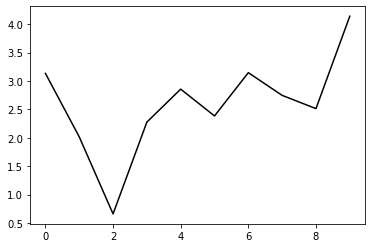

In [20]:
h=tf.zeros(layer)
h_in=[]
for i in range (layer):
    h_inn=np.float64(np.random.normal(2, 1))
    h_in.append(h_inn)
h=tf.Variable(h_in)
m2=tf.Variable(np.float64(np.random.normal(2, 1)))
lam=tf.Variable(np.float64(np.random.normal(1, 1)))
alpha=tf.Variable(np.float64(np.random.uniform(-0.5, 0.5)))
beta=tf.Variable(np.float64(np.random.uniform(-0.5, 0.5)))
#m2=tf.constant(np.float64(5.6))
#lam=tf.constant(np.float64(0.61))
#alpha=tf.constant(np.float64(1.444635))
#beta=tf.constant(np.float64(0.00615))
print("m^2=", m2)
print("lam=", lam)
print("alpha=", alpha)
print("beta=", beta)
print(h)
plt.plot(h.numpy(), 'k-')
plt.show()

In [5]:
def F_func(m, la, a,b):
    return 2*b/n_fin-m*a-la*(a**3)

def t_func(a):
    return 0.5*(tf.math.tanh(100*(a-0.1))-tf.math.tanh(100*(a+0.1))+2)

In [6]:
x=[i*0.2 for i in range (30)]
y=[0.0, 0.018, 0.035, 0.053, 0.0715, 0.0895, 0.107, 0.125, 0.146, 0.1665, 0.1875, 0.2085, 0.229, 0.25, 0.265, 0.281, 0.296, 0.3115, 0.3275, 0.343, 0.3565, 0.385, 0.4375, 0.5, 0.6, 0.675, 0.735, 0.815, 0.865, 0.885]
y[:]=[2*v for v in y]
fp1 = np.polyfit(x, y, 15)
print(fp1)

[ 1.59046394e-05 -6.81729682e-04  1.31412795e-02 -1.50525136e-01
  1.14052774e+00 -6.02241647e+00  2.27455168e+01 -6.20704699e+01
  1.22166922e+02 -1.71187074e+02  1.66428955e+02 -1.07461552e+02
  4.28229887e+01 -9.20544914e+00  9.55260239e-01 -1.30911492e-04]


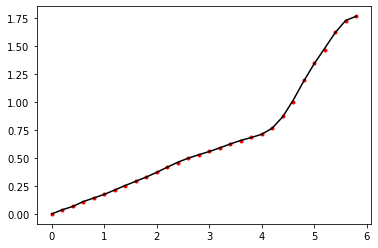

In [7]:
def f(x):
    y=0
    for i in range (16):
        y=y+fp1[i]*x**(15-i)
    return y
yy=[f(i*0.2) for i in range (30)]
plt.plot(x, y, 'r.')
plt.plot(x, yy, 'k-')
plt.show()

In [8]:
def NN_func_p(f):
    Positive=[]
    append=Positive.append
    while len(Positive)<batch:
        H=np.random.uniform(0.0, 6.0)
        M=np.random.uniform(0.0, 2.0)
        noise=np.abs(np.random.normal(0, 0.1))
        if np.abs(M-f(H))<=noise: append([H, M])
        else: continue
    return Positive
def NN_func_n(f):
    Negative=[]
    append=Negative.append
    while len(Negative)<batch:
        H=np.random.uniform(0.0, 6.0)
        M=np.random.uniform(0.0, 2.0)
        noise=np.abs(np.random.normal(0, 0.1))
        if np.abs(M-f(H))>noise: append([H, M])
        else: continue
    return Negative

In [9]:
Positive=[]
Negative=[]
for i in range (set):
    Positive.insert(i, NN_func_p(f))
    Negative.insert(i, NN_func_n(f))

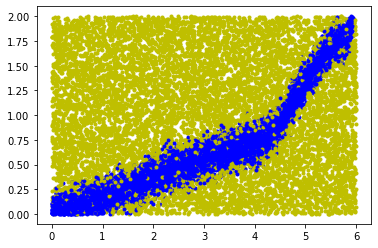

In [10]:
x_data1=[]
y_data1=[]
x_data2=[]
y_data2=[]
for i in range (set):
    x_data1.insert(i, [v[0] for v in Positive[i]])
    y_data1.insert(i, [v[1] for v in Positive[i]])
    x_data2.insert(i, [v[0] for v in Negative[i]])
    y_data2.insert(i, [v[1] for v in Negative[i]])
    plt.plot(x_data2[i], y_data2[i], 'y.')
    plt.plot(x_data1[i], y_data1[i], 'b.')
plt.show()

In [11]:
def Dfunc(hh, m):
    D=tf.math.sqrt(tf.math.abs(1+4*m/(hh[0]**2)))
    return D

In [12]:
def LP2(hh, m, la, alpha, beta, HH, MM):
    D=Dfunc(hh, m)
    phi=alpha*HH+beta*MM
    pi=(d/2)*(D-1)*alpha*HH+(d/2)*(-D-1)*beta*MM
    for j in range (layer-1):
        phi1=phi+dn*pi
        pi1 =phi*m*dn+(1-dn*hh[j])*pi+dn*la*(phi1**3)
        phi=phi1
        pi=pi1
    return phi, pi
def NN_func_01(hh, m, la, alpha, beta, list_hr):
    PP=[]
    NN=[]
    H=np.array(list_hr)[:, 0]
    M=np.array(list_hr)[:, 1]
    F=np.array(tf.math.abs(LP2(hh, m, la, alpha, beta, H, M)[1]))
    for i in range (len(H[F<0.1])):
        PP.append([H[F<0.1][i], M[F<0.1][i]])
    for i in range (len(H[F>=0.1])):
        NN.append([H[F>=0.1][i], M[F>=0.1][i]])
    return PP, NN

In [21]:
Positive0=[]
Positive1=[]
Negative0=[]
Negative1=[]
for i in range (set):
    Positive0.insert(i, NN_func_01(h, m2, lam, alpha, beta, Positive[i])[0])
    Positive1.insert(i, NN_func_01(h, m2, lam, alpha, beta, Positive[i])[1])
    Negative0.insert(i, NN_func_01(h, m2, lam, alpha, beta, Negative[i])[0])
    Negative1.insert(i, NN_func_01(h, m2, lam, alpha, beta, Negative[i])[1])

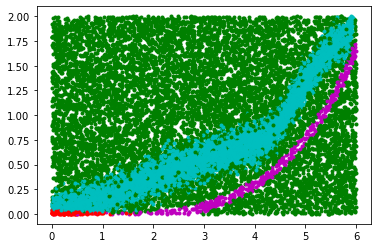

In [22]:
x_data1=[]
y_data1=[]
x_data2=[]
y_data2=[]
x_data3=[]
y_data3=[]
x_data4=[]
y_data4=[]
for i in range (set):
    x_data1.insert(i, [v[0] for v in Positive0[i]])
    y_data1.insert(i, [v[1] for v in Positive0[i]])
    x_data2.insert(i, [v[0] for v in Positive1[i]])
    y_data2.insert(i, [v[1] for v in Positive1[i]])
    x_data3.insert(i, [v[0] for v in Negative0[i]])
    y_data3.insert(i, [v[1] for v in Negative0[i]])
    x_data4.insert(i, [v[0] for v in Negative1[i]])
    y_data4.insert(i, [v[1] for v in Negative1[i]])
    plt.plot(x_data4[i], y_data4[i], 'g.')
    plt.plot(x_data2[i], y_data2[i], 'c.')
    plt.plot(x_data1[i], y_data1[i], 'r.')
    plt.plot(x_data3[i], y_data3[i], 'm.')
plt.show()

# Error function

$E=\sum_{data} \left\vert y(\bar{x}^{(1)}) - \bar{y} \right\vert+E_{reg}(W)$
, $E_{reg}=c_{reg}^{(1)}\sum_{n=1}^{N-1}(\eta^{(n)})^{4}(h(\eta^{(n+1)})-h(\eta^{(n)}))^{2}+c_{reg}^{(2)}(h(\eta^{(N)})-1/\eta^{(N)})^{2}$

In [15]:
def Error_func(hh, m, la, alpha, beta, list1, list2):
    H0=np.array([v[0] for v in list1])
    M0=np.array([v[1] for v in list1])
    H1=np.array([v[0] for v in list2])
    M1=np.array([v[1] for v in list2])
    H_0, M_0=LP2(hh, m, la, alpha, beta, H0, M0)
    H_1, M_1=LP2(hh, m, la, alpha, beta, H1, M1)
    PPlist=t_func(M_0)
    NNlist=t_func(M_1)
    sum_p=sum(PPlist)/batch
    sum_n=(batch-sum(NNlist))/batch

    inside=0
    for k in range (layer-1):
        second=((n_ini+k*dn)**4)*((hh[k+1]-hh[k])**2)
        inside=inside+second
    E_reg1=c_reg1*inside
    E_reg2=c_reg2*((hh[layer-1]-1/n_fin)**2)
    return sum_n+sum_p+E_reg1+E_reg2

In [16]:
for i in range (set):
    print(Error_func(h, m2, lam, alpha, beta, Positive[i], Negative[i]))

tf.Tensor(1.0463540426520705, shape=(), dtype=float64)
tf.Tensor(1.0179830454788912, shape=(), dtype=float64)
tf.Tensor(1.0363540879628619, shape=(), dtype=float64)
tf.Tensor(1.0315807452885082, shape=(), dtype=float64)
tf.Tensor(1.0263540893747498, shape=(), dtype=float64)
tf.Tensor(1.0457588242186364, shape=(), dtype=float64)
tf.Tensor(1.0364559696541846, shape=(), dtype=float64)
tf.Tensor(1.0363540890629894, shape=(), dtype=float64)
tf.Tensor(1.0263540891534932, shape=(), dtype=float64)
tf.Tensor(1.0381532868504355, shape=(), dtype=float64)
tf.Tensor(1.0463540873654094, shape=(), dtype=float64)
tf.Tensor(1.0375547870391153, shape=(), dtype=float64)
tf.Tensor(1.0263620847695358, shape=(), dtype=float64)
tf.Tensor(1.036355715565363, shape=(), dtype=float64)
tf.Tensor(1.0263541657906796, shape=(), dtype=float64)
tf.Tensor(1.036487693238228, shape=(), dtype=float64)
tf.Tensor(1.0263540902728925, shape=(), dtype=float64)
tf.Tensor(1.0458627171204913, shape=(), dtype=float64)
tf.Tensor(1.

# Optimize

0 1.0888001297666225
0.3410674455566959 -0.0565631746478545 0.44198548640437435 0.10942318359822141
[3.18435981 1.96617015 0.70835749 2.22609129 2.80642219 2.4345958
 3.09666053 2.79661386 2.56351134 4.19068315]


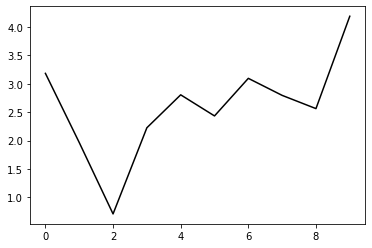

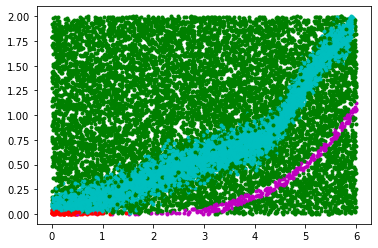

1000 1.0110431259721446
0.3812108214819249 -0.05848662481754348 0.424739069321389 0.13055826396324216
[2.52062751 2.72512357 2.92344398 3.00224138 2.99028645 2.98243179
 3.04476906 3.12607185 3.14793535 8.2689921 ]


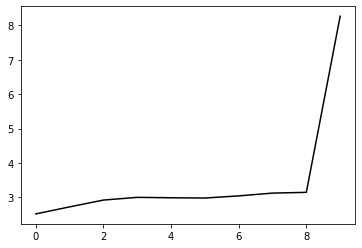

2000 0.9968571556030361
0.3579578485077132 0.003298229425066389 0.3758364836281554 0.1720089188466267
[3.17664699 2.99355833 2.76650092 2.48588886 2.14077824 1.75971514
 1.44819547 1.49911584 2.4148325  8.52144032]


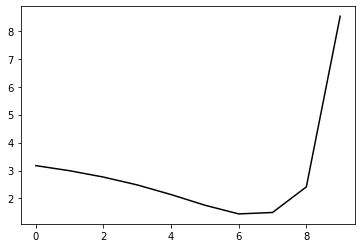

3000 0.7691934553238349
0.2874759910442985 0.04511664514697323 0.3744985266499622 0.05125089566898189
[ 1.93574336  2.1381822   2.00624372  1.58672386  0.95178495  0.17874891
 -0.65659499 -1.23520261 -0.56380543  7.90430459]


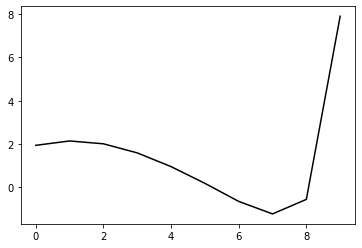

4000 0.25564978813879646
0.2911099663095429 -0.0668512971141913 0.3500638075793618 0.07646139715846476
[ 1.8359625   1.84910773  1.78823896  1.5822479   1.12555161  0.36952019
 -0.59111646 -1.39920373 -0.98018778  7.88885045]


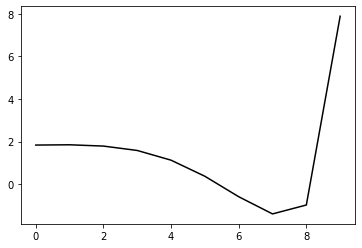

5000 0.20520983536179618
0.2908214835419245 -0.06088695583546426 0.33613202174361717 0.08223815403485964
[ 1.80627896  1.74688571  1.69249801  1.5277599   1.18302874  0.54406732
 -0.44404215 -1.46972088 -1.30150433  7.81864894]


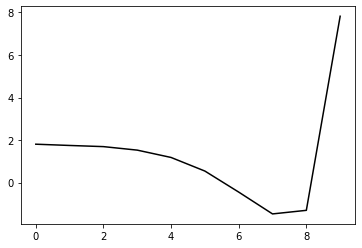

6000 0.3272400131089615
0.28341434852733244 -0.0700858219928737 0.33386653701051405 0.08421777681869616
[ 1.69259283  1.84177799  1.78015729  1.61705603  1.29702712  0.70825916
 -0.257677   -1.42829981 -1.4895166   7.8033309 ]


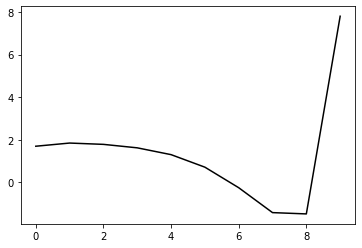

7000 0.3006779657539696
0.27958062023660457 -0.07117112672293947 0.3297021989156118 0.08708728681027764
[ 1.61645007  1.72408281  1.69807083  1.57289889  1.29858692  0.77192204
 -0.13676592 -1.36029148 -1.58859508  7.74882115]


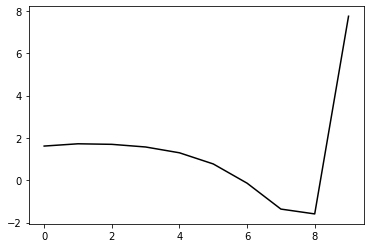

8000 0.2681819317371399
0.2643959677916655 -0.07501887634470997 0.3244195030375677 0.0926900769901804
[ 1.61678302  1.62695636  1.57751788  1.45209767  1.19606762  0.71643519
 -0.13142733 -1.37778133 -1.77408611  7.72699227]


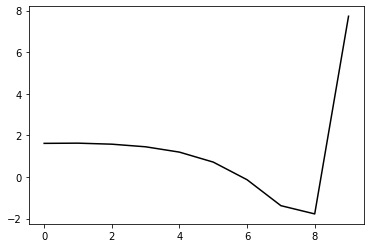

9000 0.2374145886571572
0.262147344902797 -0.07574071864084664 0.31846165652462416 0.09489768548761174
[ 1.55397626  1.58793437  1.53223998  1.3872302   1.10899567  0.62087778
 -0.215722   -1.49299919 -2.06422754  7.65086857]


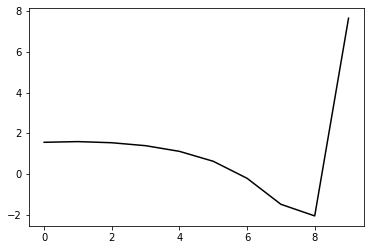

10000 0.17833892908776447
0.2552005976192408 -0.08031262897359963 0.3154025854110893 0.09973655336862701
[ 1.55126762  1.50229638  1.42291811  1.26203205  0.99324982  0.53443829
 -0.2633137  -1.52175775 -2.20820427  7.61339919]


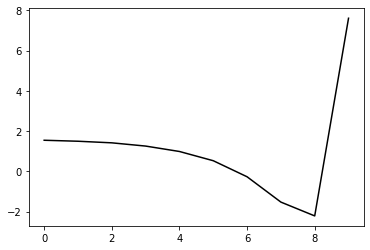

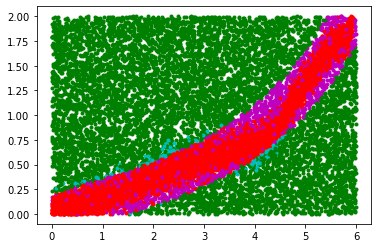

11000 0.27644923172454205
0.25387402213765 -0.07882024873212344 0.30714111369805835 0.10775670457900237
[ 1.54066469  1.47464316  1.36705353  1.21299922  0.95120504  0.48882165
 -0.30719783 -1.56919912 -2.36633781  7.57362261]


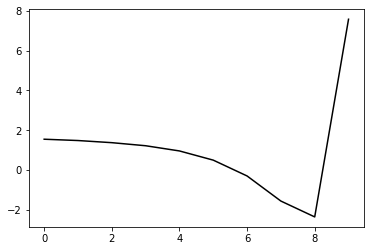

12000 0.20558852711364234
0.25848207853640215 -0.08378524214318678 0.30746782692959196 0.11085994056384184
[ 1.43499102  1.54669216  1.50867436  1.38768915  1.1521524   0.71507695
 -0.05951013 -1.31387182 -2.20855365  7.64132085]


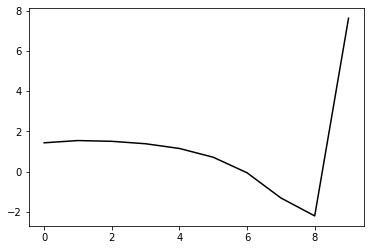

13000 0.27778710612552754
0.2555642813422465 -0.08846939744170311 0.3077209006205089 0.10979435116551477
[ 1.40680105  1.44946462  1.41012697  1.2842819   1.05204086  0.62970006
 -0.12624523 -1.38316517 -2.39202125  7.60134064]


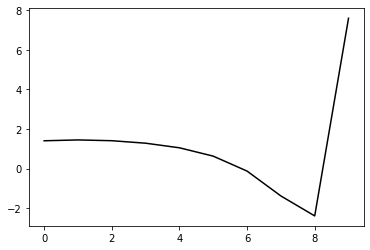

14000 0.1414279393975712
0.2547717657724912 -0.08724532890079216 0.30314672865902254 0.11312801994472538
[ 1.40857635  1.46879924  1.41621978  1.29462436  1.07929207  0.68738165
 -0.0292482  -1.25715888 -2.33255353  7.64812238]


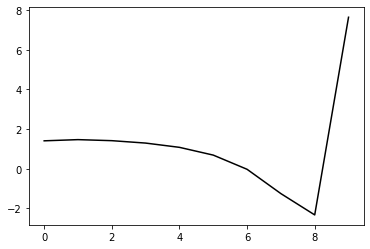

15000 0.16806110430417473
0.24990049452046378 -0.0872871232604688 0.29756732141798414 0.11771277843998518
[ 1.43167625  1.41369779  1.35865463  1.24802822  1.04050377  0.65533613
 -0.04247509 -1.24888778 -2.37343558  7.62427901]


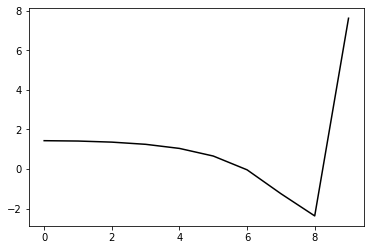

16000 0.2435752007805051
0.24316459496479206 -0.0941301600371586 0.2982316771814226 0.1184724067939305
[ 1.43366794  1.37769651  1.30262795  1.1730552   0.948458    0.57258757
 -0.08855372 -1.24811205 -2.4068944   7.6439665 ]


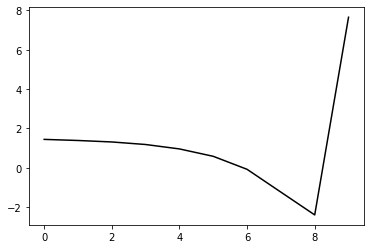

17000 0.21367387196788848
0.24398461325530924 -0.09621305439301794 0.2953167269487016 0.11728689967567967
[ 1.38420015  1.29790128  1.21065423  1.07328882  0.84533287  0.46208509
 -0.19968831 -1.33921457 -2.52616929  7.57138892]


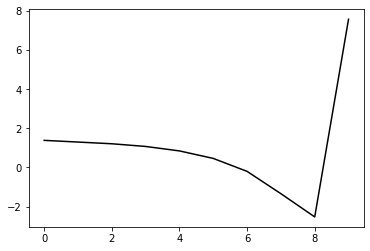

18000 0.23970172056890873
0.24905318798822645 -0.0959770316962705 0.2917649778326587 0.11863356388743522
[ 1.32230117  1.37755726  1.33737634  1.23064561  1.01229718  0.61995566
 -0.05460575 -1.19589085 -2.41747963  7.60793557]


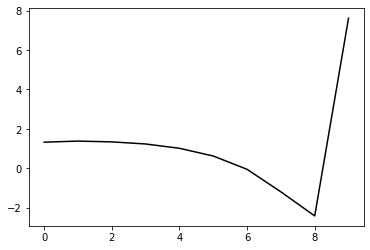

19000 0.23291533829021882
0.2433842672052538 -0.10207171975019826 0.29129787026382536 0.12125622102302082
[ 1.31420547  1.24241628  1.12985586  1.00008051  0.7918345   0.42188827
 -0.23542854 -1.36431186 -2.59980016  7.52945373]


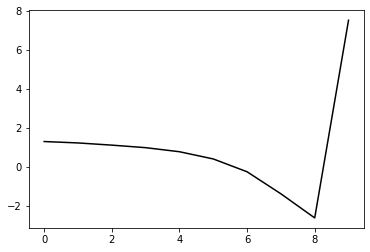

20000 0.22847243604016046
0.24389035030656706 -0.09946899160933831 0.28791209010276925 0.12290932615595908
[ 1.28443073  1.31426856  1.23624327  1.09634288  0.87003617  0.49874712
 -0.14191394 -1.25503013 -2.50709798  7.58009701]


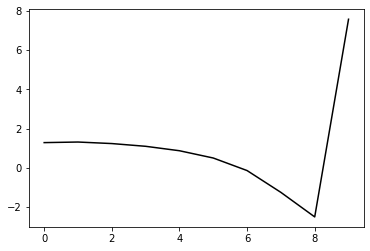

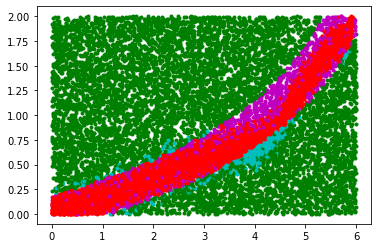

21000 0.21280990467972905
0.23962068024569266 -0.10080698914129176 0.2873725718316235 0.12296416898125156
[ 1.2837269   1.32773798  1.27059733  1.15786826  0.95471357  0.60597346
 -0.0082213  -1.089786   -2.33925656  7.61792329]


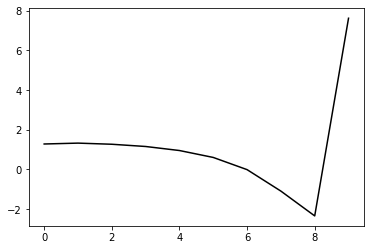

22000 0.19253296334335626
0.23774013004058503 -0.10137310237538019 0.28568302062684403 0.12385839956132728
[ 1.28480294  1.30887291  1.22560109  1.10306553  0.90520805  0.56594809
 -0.02806519 -1.07908492 -2.31912353  7.61456501]


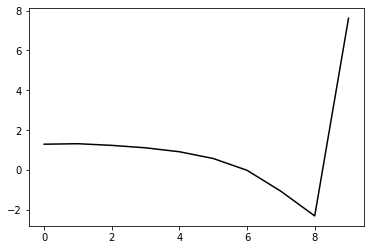

23000 0.21070880225397878
0.2381120920174772 -0.10431983123818744 0.2820041770687107 0.12659106371883766
[ 1.2942624   1.34632072  1.28134662  1.13148471  0.88993922  0.51407733
 -0.10211867 -1.15495352 -2.40267301  7.630877  ]


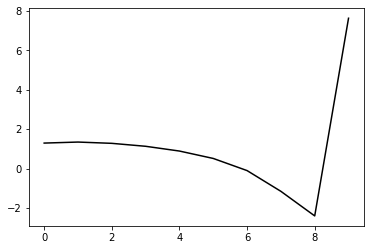

24000 0.10679272573587088
0.23594334350588123 -0.10559827614857528 0.28049930927755995 0.12383576287338836
[ 1.29953157  1.18074493  1.06658087  0.93150289  0.72067058  0.35601898
 -0.26920527 -1.32358133 -2.57014468  7.53343401]


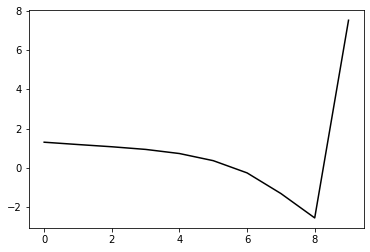

25000 0.2319513942920755
0.23749712226719888 -0.10711146567177388 0.2820101814949499 0.12163299736102509
[ 1.27163492  1.23793401  1.16915273  1.04755276  0.83825413  0.48496061
 -0.12212063 -1.16894942 -2.41916098  7.59873632]


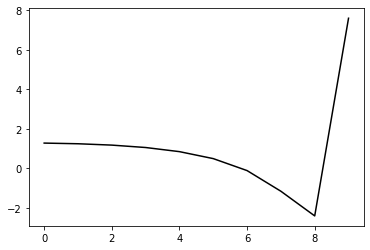

26000 0.20749077898697507
0.2414781619667437 -0.10530586057075343 0.2782516781855393 0.12561740474754957
[ 1.26812029  1.3233976   1.25053452  1.12249353  0.91762825  0.55956416
 -0.06386009 -1.12599684 -2.39146294  7.60576669]


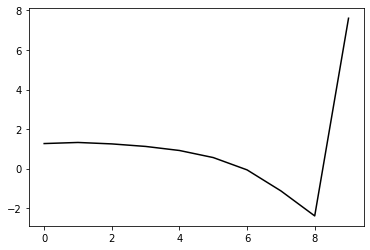

27000 0.25093135212781825
0.24047387166440817 -0.11034705489776887 0.28011833206204745 0.11960539439894227
[ 1.27966233  1.22964351  1.10578305  0.95602989  0.73953602  0.38384502
 -0.22617636 -1.27846901 -2.53861634  7.54066958]


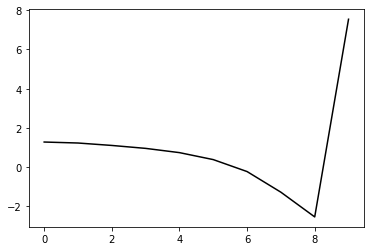

28000 0.20551392322257048
0.23851779197556536 -0.10894542616388583 0.27733908846985417 0.12329834495148713
[ 1.27893912  1.22349885  1.11863427  0.97991962  0.77115719  0.41926593
 -0.18648348 -1.23201247 -2.492908    7.56648229]


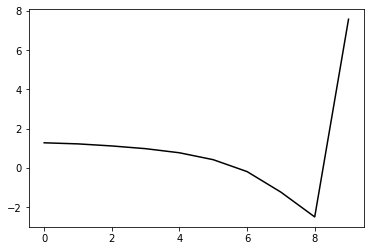

29000 0.27869965262336993
0.2384888418350825 -0.1105433208159257 0.2773718222729242 0.12318650720465261
[ 1.25636523  1.30799187  1.23929375  1.11059196  0.89514932  0.53769199
 -0.0669966  -1.10934981 -2.37371323  7.61830146]


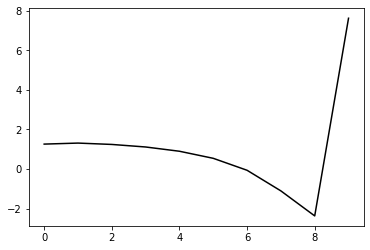

30000 0.1991032610259948
0.23878838875871225 -0.10886907972813543 0.2743983356249123 0.12345858361924332
[ 1.2582241   1.32702788  1.25868427  1.12979262  0.91963201  0.56492225
 -0.04276956 -1.08774308 -2.35819401  7.60363106]


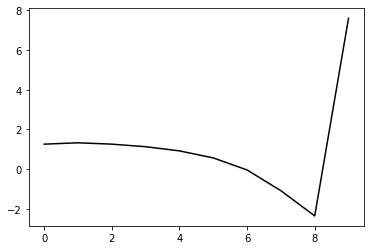

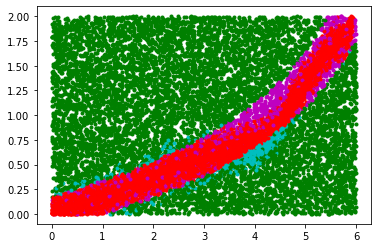

31000 0.21626086351149088
0.23815636908445484 -0.10922147683482553 0.27347934227167175 0.11999534123037288
[ 1.25569571  1.28399779  1.19093187  1.05873965  0.8463171   0.4954273
 -0.1068647  -1.14642456 -2.4113603   7.57348894]


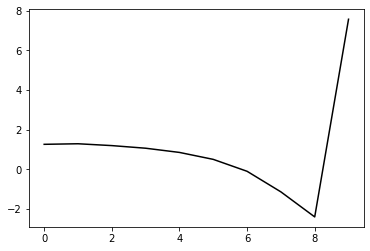

32000 0.19522764526027708
0.2348610407904332 -0.11009990304441636 0.27280043894567024 0.12278751205249308
[ 1.27173763e+00  1.30601181e+00  1.22952279e+00  1.10195383e+00
  8.99078006e-01  5.70234219e-01 -1.26096957e-03 -1.00873089e+00
 -2.24345311e+00  7.62993728e+00]


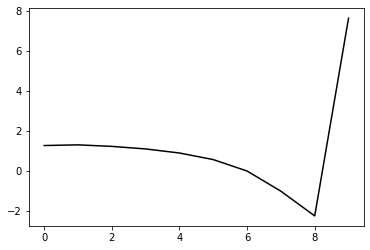

33000 0.20239698351184676
0.23782452367004714 -0.11215361108661911 0.2722518067935035 0.12199545220898711
[ 1.2718371   1.28272342  1.20402699  1.055648    0.83839318  0.49748467
 -0.07385272 -1.06670839 -2.28224624  7.57794188]


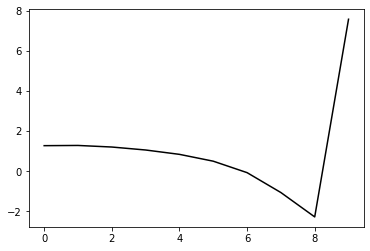

34000 0.3185920503085341
0.239973227048263 -0.11340500765204588 0.2721955073447394 0.12191438287723678
[ 1.25412791e+00  1.32444873e+00  1.26884494e+00  1.14428884e+00
  9.29120105e-01  5.82019665e-01  5.09407792e-03 -9.82589301e-01
 -2.18796575e+00  7.63205339e+00]


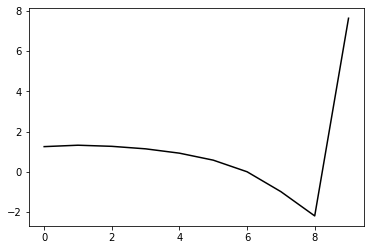

35000 0.1719615254942414
0.2387219511662525 -0.11347596463295986 0.27060819953142745 0.11969698362132111
[ 1.27826248  1.20412466  1.1279059   0.99729889  0.78667987  0.43860143
 -0.1447786  -1.13217282 -2.3243404   7.62778591]


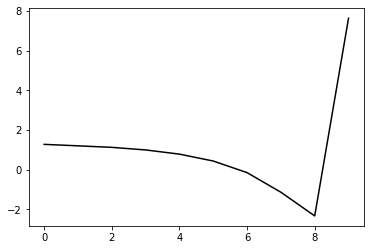

36000 0.15207927566315257
0.23413144379453818 -0.11871814660943526 0.27207094907119245 0.11840826058826172
[ 1.26496471  1.22286524  1.10140263  0.95636585  0.74363961  0.39600498
 -0.18941496 -1.1812426  -2.37139695  7.58613943]


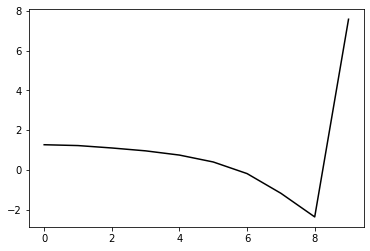

37000 0.2142860164132709
0.2403448694818151 -0.1152560389666168 0.2686593636620697 0.11941818698523539
[ 1.26083214  1.39065259  1.33780013  1.17996656  0.94170548  0.57557946
 -0.02276695 -1.02610105 -2.22439999  7.63831671]


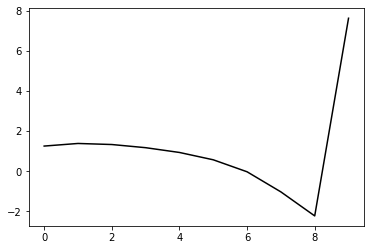

38000 0.16675232082539931
0.2359531103337827 -0.11370636146494996 0.2656412628923258 0.12025962313991848
[ 1.29649529  1.2773702   1.19724136  1.06812814  0.86138249  0.51405159
 -0.07734794 -1.07417008 -2.2534582   7.62656309]


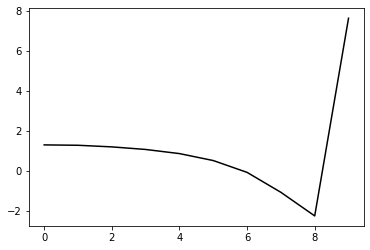

39000 0.1467626033478492
0.23652911442917 -0.1161301185170162 0.265795315419 0.12096900203900236
[ 1.27696128  1.25062631  1.17326921  1.03659491  0.82897153  0.49658968
 -0.06559506 -1.03157853 -2.17134788  7.61642485]


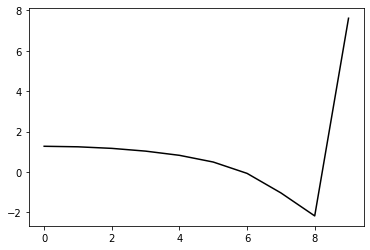

40000 0.24466099519744378
0.2354703750102679 -0.11971801377802216 0.2673416354972356 0.11869526344191149
[ 1.26639076  1.20827776  1.13398713  1.00501445  0.80186618  0.46563572
 -0.09498751 -1.04715655 -2.16649496  7.64892942]


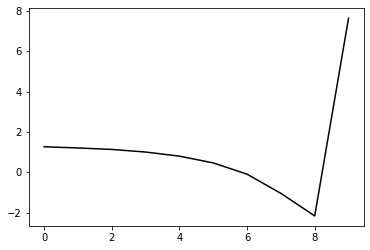

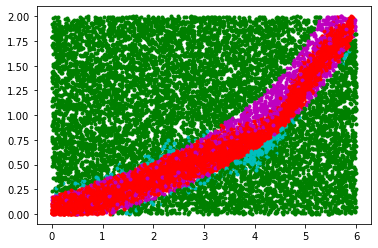

41000 0.18996194091357554
0.23046599021415665 -0.1212026407108907 0.2667022283290866 0.1189094468418589
[ 1.25476819  1.31790688  1.23148562  1.0678804   0.84689698  0.52316943
 -0.01263265 -0.93339394 -2.01432275  7.67514536]


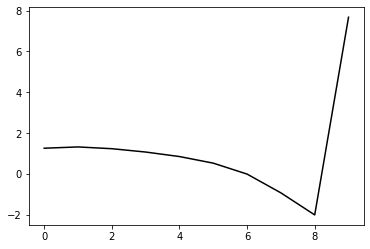

42000 0.18088259482146768
0.2284330689801666 -0.12027085134096496 0.26314488233820577 0.11850371067129425
[ 1.27231133  1.18573336  1.07440317  0.9204007   0.69265351  0.33804016
 -0.22918913 -1.16175748 -2.23781206  7.59759286]


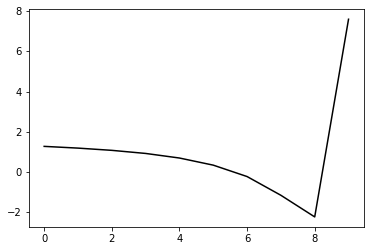

43000 0.19721672850419997
0.23130953510756389 -0.12019312341748302 0.26193042387450655 0.11677941579348408
[ 1.24024159  1.22813667  1.13308259  0.99243907  0.77477471  0.42304249
 -0.15450543 -1.09613626 -2.16334304  7.63299508]


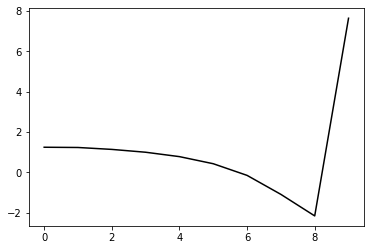

44000 0.21935878120432487
0.22957931000856477 -0.12315304184781298 0.26259814786252267 0.11817063515660721
[ 1.231833    1.22134357  1.1482957   1.03715473  0.84045555  0.49728796
 -0.08223043 -1.03624437 -2.10622779  7.63924541]


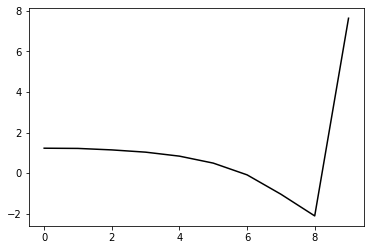

45000 0.22134741938026592
0.22470496568051132 -0.12266691485516991 0.26030640621978923 0.12052206378518655
[ 1.22309337  1.24483282  1.16892951  1.03665667  0.83012338  0.49810519
 -0.06528466 -1.01698819 -2.08515133  7.64661615]


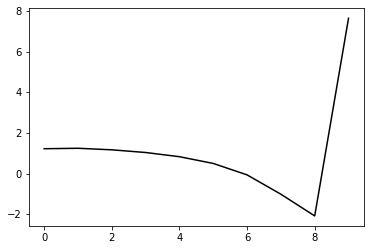

46000 0.22969544262641373
0.22407161710444062 -0.12310328631928903 0.26002001916901835 0.11484539690562726
[ 1.23415119  1.13436468  1.00813781  0.85465924  0.63843151  0.30374021
 -0.25404564 -1.19812557 -2.26005883  7.66044655]


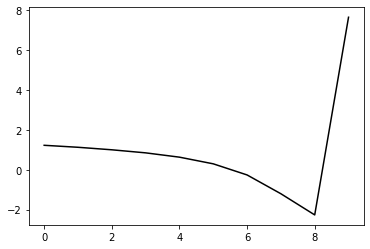

47000 0.3493568863431727
0.22248329649236312 -0.12147631439027382 0.25896764518433585 0.11682467182806744
[ 1.21306589  1.20984618  1.10481459  0.97088755  0.7716108   0.45119842
 -0.09045651 -1.01371868 -2.05680205  7.66276501]


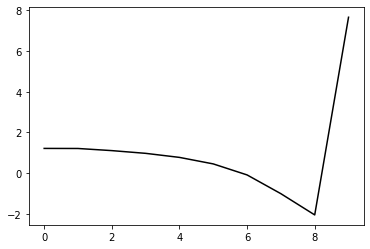

48000 0.15150338961381682
0.21755218133976134 -0.12213330663448932 0.25610343381021494 0.12290735110529014
[ 1.27536866  1.17517812  1.08522987  0.93823954  0.72374847  0.39838495
 -0.1348548  -1.03813703 -2.05588329  7.62720066]


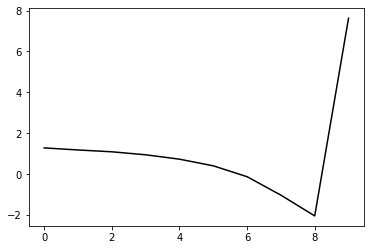

49000 0.1651875136843653
0.21978220703333676 -0.12423135590617328 0.256792305907621 0.12072979851285524
[ 1.22278328  1.13150701  1.01784286  0.87347316  0.66057685  0.32253667
 -0.22848957 -1.13060286 -2.12789517  7.63332694]


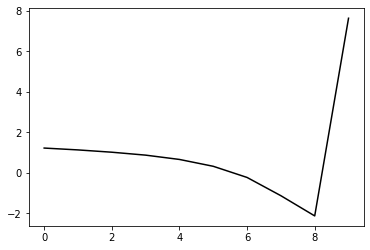

50000 0.25354860384508804
0.22209022765231018 -0.12502178584344398 0.25763133133519256 0.12283601820919324
[ 1.21320462  1.22217415  1.14816972  1.01704122  0.80790142  0.47528808
 -0.07014496 -0.97251664 -1.96968318  7.67666231]


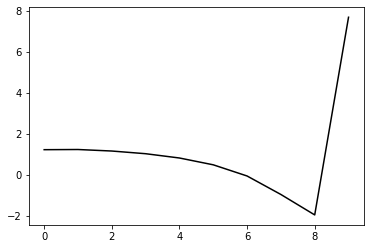

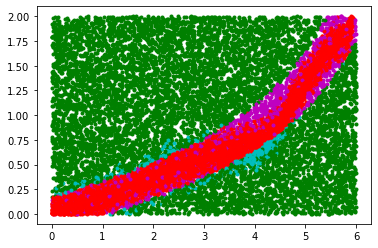

51000 0.24102280225294564
0.2210761837724499 -0.12291324786015116 0.256980743282614 0.11985484900552078
[ 1.24002725  1.16813585  1.08274358  0.94446586  0.74694608  0.43464315
 -0.09373224 -0.98451583 -1.96840954  7.68782134]


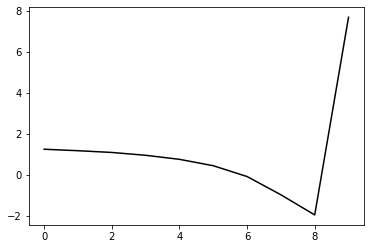

52000 0.18490355573605716
0.21604451002476277 -0.12281675204738371 0.2541125368793445 0.12241727437222877
[ 1.25069488  1.11501292  1.00620275  0.86313816  0.65565471  0.33536153
 -0.18520572 -1.05792709 -2.01777956  7.65138648]


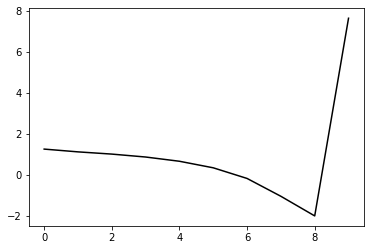

53000 0.23425166922888543
0.2207189513553368 -0.1263414823018637 0.2571931143735057 0.12172779693664557
[ 1.17931779  1.23860991  1.15159549  0.99716997  0.77856424  0.45222154
 -0.07057098 -0.92975676 -1.86127794  7.70546232]


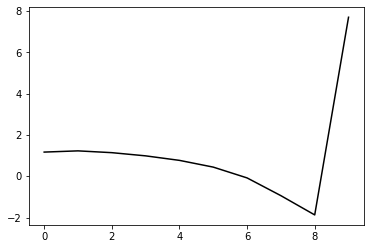

54000 0.2827684920336902
0.22424398272889767 -0.12737416367112725 0.25719363183403066 0.11866394318901474
[ 1.16751299  1.1699731   1.09050214  0.95814414  0.75169488  0.41691437
 -0.1237643  -0.99587311 -1.92996867  7.69815236]


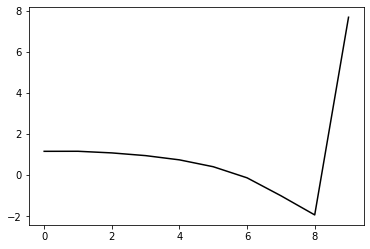

55000 0.20706453564905827
0.21652302902006887 -0.12807577314713645 0.25576083536571675 0.12288209665405153
[ 1.20492031  1.2013375   1.13798002  1.01897685  0.81557271  0.48826592
 -0.04579167 -0.91777696 -1.84676413  7.71463714]


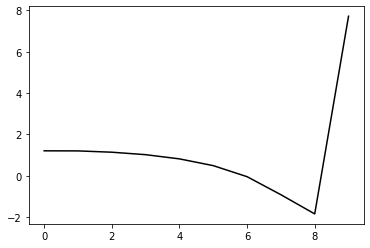

56000 0.16723412962501089
0.2155304200558064 -0.12575477131201288 0.25358707169227146 0.12090566321823926
[ 1.19168662  1.15740048  1.08814481  0.95657144  0.74458067  0.41935328
 -0.1083614  -0.97452478 -1.8895605   7.67049316]


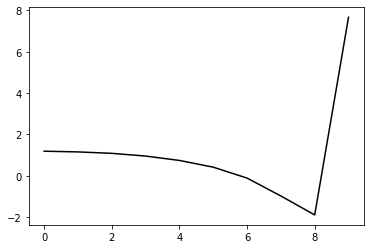

57000 0.23189176636771455
0.21610851902413952 -0.12977147343797432 0.25483001431279734 0.12063492637747367
[ 1.16886102  1.20793144  1.08703786  0.90924862  0.67751535  0.34947731
 -0.17210141 -1.02755247 -1.92540454  7.70028929]


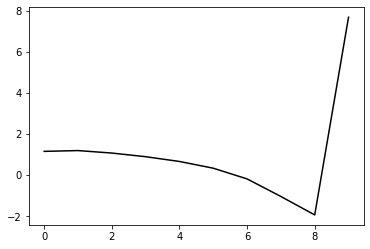

58000 0.28419364183610574
0.21585449648083607 -0.12426581623663077 0.25177181866814013 0.11886514010744546
[ 1.19113751  1.23787671  1.14768137  1.01219278  0.80655295  0.47731184
 -0.05456441 -0.91842728 -1.82795783  7.71055326]


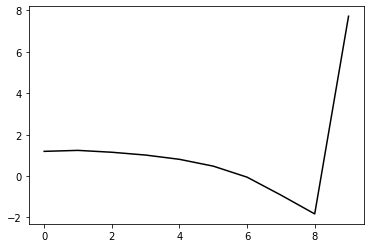

59000 0.2243221428123265
0.21486251346681928 -0.12746546754722274 0.2508105083420643 0.12060701947354231
[ 1.21061688  1.14861949  1.03780174  0.89393705  0.69434166  0.37125189
 -0.15750034 -1.01227723 -1.89534288  7.68485824]


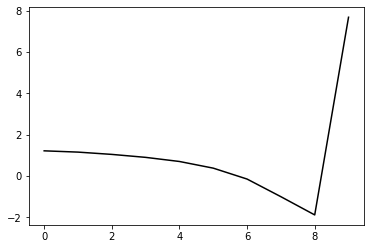

60000 0.1640294833482125
0.2129398632244096 -0.12878257588721873 0.25221944963208276 0.12034625065614381
[ 1.201879    1.23440175  1.16196389  1.03081689  0.83292741  0.51420894
 -0.00976832 -0.86586845 -1.75053578  7.72679065]


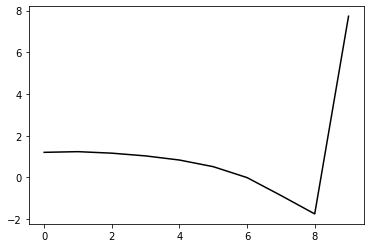

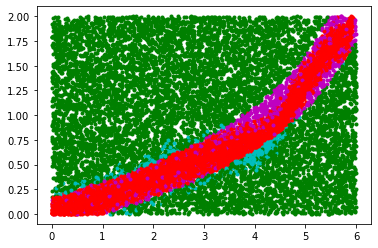

61000 0.15286473965004602
0.20861371630300618 -0.12485992891761831 0.24807073680487388 0.11799411446146453
[ 1.25282642  1.12661004  1.0327689   0.88044112  0.65902294  0.33619457
 -0.17919461 -1.02504673 -1.89565079  7.71495234]


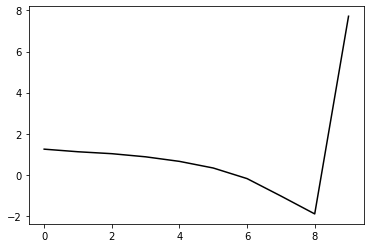

62000 0.15021153702803194
0.21263108255922256 -0.12787232719631186 0.25019279079728785 0.1176117798236994
[ 1.17554062  1.19173178  1.10163777  0.95949099  0.74695032  0.41409496
 -0.11437995 -0.96249931 -1.82687282  7.7154462 ]


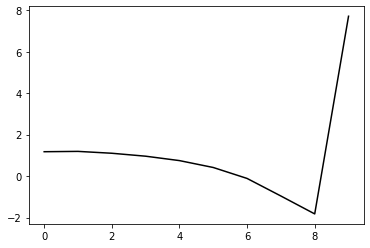

63000 0.20859490330049035
0.21258472198460382 -0.12948183492637838 0.25122879272606474 0.11548294383986088
[ 1.22197252  1.1560063   1.07726974  0.92377699  0.69977673  0.36938729
 -0.15583287 -0.99983251 -1.85085553  7.71394324]


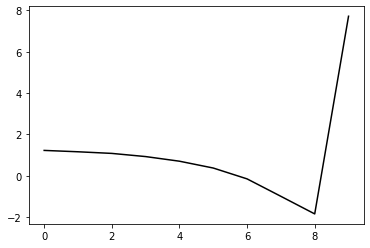

64000 0.17698046782596513
0.207513622002154 -0.1297673410292998 0.2500871893008835 0.11496130015138195
[ 1.24394623  1.09311785  0.96936433  0.81651763  0.60263708  0.27706383
 -0.249657   -1.09486752 -1.93866576  7.65408713]


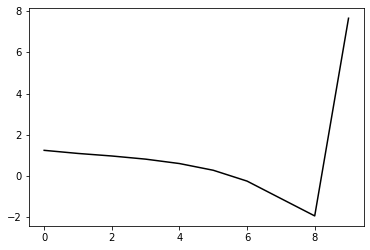

65000 0.23823885408235268
0.21671628658263115 -0.13058926245916888 0.25079667187659643 0.11821176026907182
[ 1.18122509e+00  1.24552823e+00  1.18266104e+00  1.06406881e+00
  8.65333121e-01  5.35786899e-01  5.78083040e-03 -8.33530109e-01
 -1.66010142e+00  7.75848430e+00]


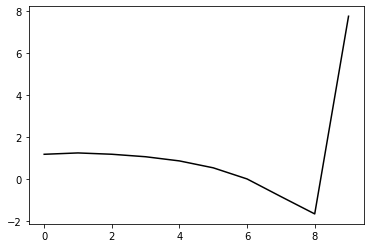

66000 0.1944678454562877
0.21474575800714749 -0.13148336565829177 0.2502587447696685 0.11739477762923778
[ 1.21303708  1.188186    1.12562761  1.0025104   0.79824524  0.46745411
 -0.07128893 -0.92695627 -1.76183971  7.72609694]


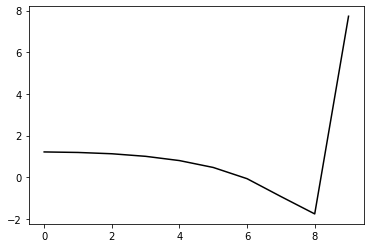

67000 0.25737612274846466
0.21581058347105175 -0.13140648172423028 0.25033373024839145 0.11175029456720438
[ 1.20406356  1.23533333  1.11996219  0.97570876  0.76655119  0.43715155
 -0.10110386 -0.96535108 -1.80960939  7.71325924]


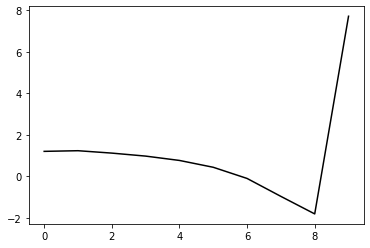

68000 0.3267020697286865
0.219162931588406 -0.13184504288727283 0.2499422994060715 0.11014696946565634
[ 1.20050916  1.11647466  0.98954881  0.84099465  0.63222341  0.30668389
 -0.22624528 -1.08811823 -1.93158098  7.69431465]


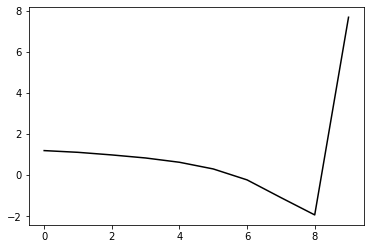

69000 0.22908312458046573
0.21573637636006088 -0.1370397985833466 0.25125912499778874 0.11414783635744295
[ 1.20496551  1.16329123  1.04101225  0.89468746  0.67495073  0.33794049
 -0.191978   -1.03966198 -1.86233012  7.67995482]


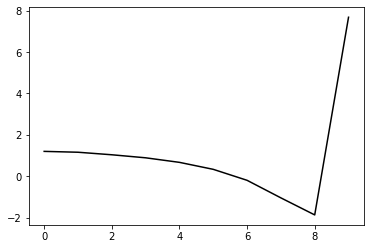

70000 0.23961611241131217
0.21865912882483454 -0.13427162946295035 0.2487060702430341 0.11789234214698807
[ 1.22488395  1.16573716  1.09609738  0.98496317  0.79338107  0.46736141
 -0.06295515 -0.90417569 -1.71520565  7.75040962]


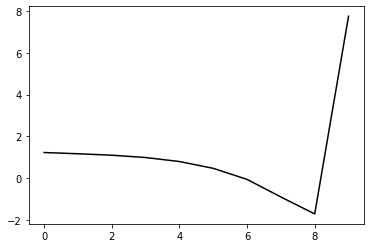

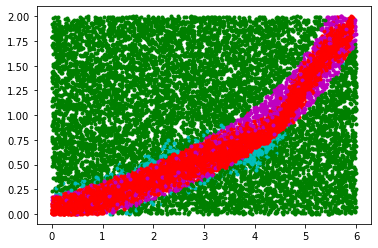

71000 0.26814550850273106
0.21622508736890797 -0.13611932306070665 0.24974562258574437 0.11169862335326054
[ 1.20610778  1.15021872  1.0201222   0.89047116  0.70166263  0.38846607
 -0.13143414 -0.96970549 -1.77701756  7.73383656]


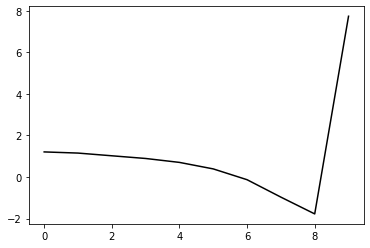

72000 0.20655900188424395
0.21756184123414246 -0.13470375518350333 0.24786565154610682 0.11873815894178961
[ 1.21213319  1.19536412  1.11331506  0.98576978  0.7845029   0.471011
 -0.03673218 -0.85835072 -1.64457912  7.72971559]


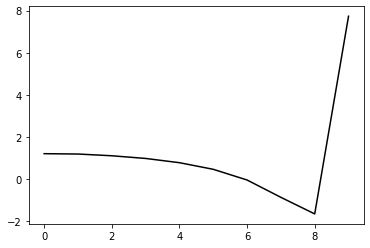

73000 0.22643317969834095
0.2206119460021889 -0.13847807006207885 0.2493381844082634 0.11181571995207334
[ 1.22334289  1.16470044  1.03460443  0.86807627  0.63079206  0.28665497
 -0.24476455 -1.0823007  -1.8807171   7.68639895]


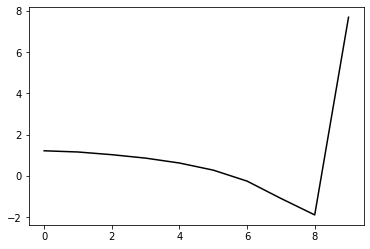

74000 0.2215493622362532
0.22223573095809407 -0.13577025917851146 0.2480620160154348 0.11740060117549692
[ 1.20911375  1.22139441  1.15271221  1.04363487  0.84795541  0.51305226
 -0.02559247 -0.86630416 -1.66097205  7.7484676 ]


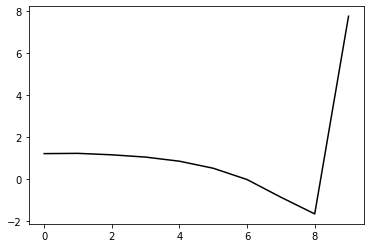

75000 0.23724561106963948
0.22533731379329003 -0.13037506539048824 0.24413104405378544 0.11649103084081329
[ 1.21816722  1.26659081  1.18242521  1.04508875  0.83617529  0.50058203
 -0.04513319 -0.90581782 -1.7205466   7.73453621]


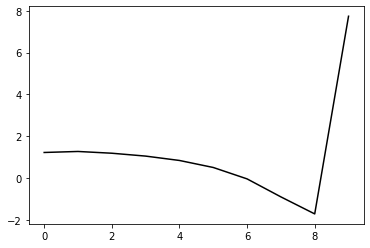

76000 0.21015102527134474
0.22221709309235177 -0.13604578208196041 0.24583863480376364 0.11662489461061849
[ 1.2176869   1.24747818  1.18108203  1.05974402  0.85398449  0.52299289
 -0.01146238 -0.86625891 -1.67723123  7.77073307]


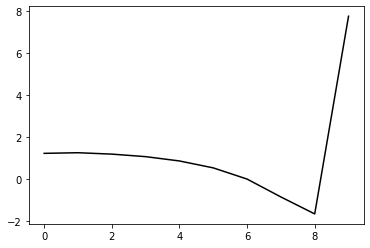

77000 0.3029148268034199
0.22424604259438413 -0.1354443609001517 0.2456083867382656 0.11318728000282222
[ 1.20879663  1.23673987  1.1468167   1.01628425  0.81758142  0.48929039
 -0.05093756 -0.91612081 -1.74201623  7.72890433]


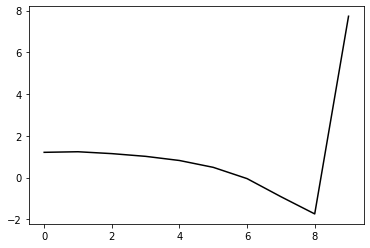

78000 0.22203772624968096
0.22242885123894154 -0.13945458276582026 0.2483087907342223 0.11379402947762017
[ 1.23394431  1.18031962  1.11247457  0.98188179  0.78285707  0.47519372
 -0.03438054 -0.87369507 -1.67914285  7.73385352]


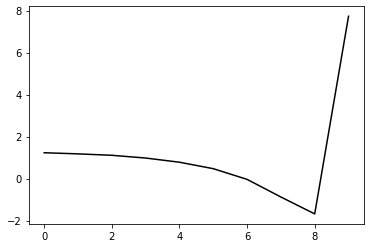

79000 0.21475620328751244
0.22222193978569862 -0.13805951888122725 0.2479822185574964 0.11236444996473806
[ 1.20887208  1.22986731  1.1564273   1.03774699  0.84484242  0.52871849
  0.01082933 -0.83466234 -1.65875713  7.73828336]


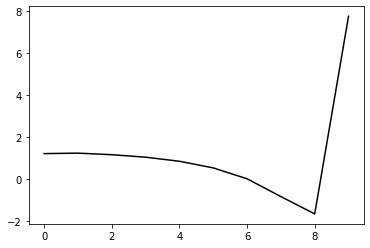

80000 0.21459486392891658
0.2175498207372663 -0.1327376657984562 0.24245219384427436 0.11342758375796855
[ 1.26783167  1.16742828  1.08093174  0.96279387  0.76700603  0.44649616
 -0.07769153 -0.92800809 -1.76104158  7.72371156]


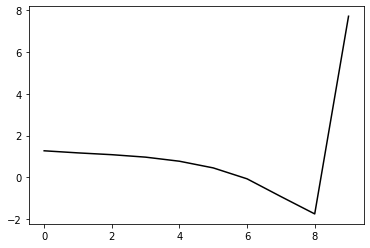

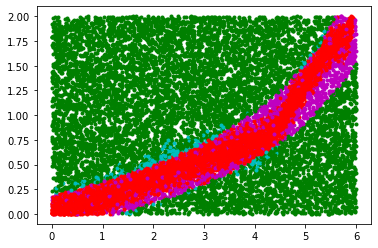

81000 0.3877690725512916
0.21825384324422464 -0.14092710412738807 0.24860594691058174 0.11067288081648421
[ 1.20399425  1.23798872  1.15615684  1.02087867  0.82795826  0.52390006
  0.01770718 -0.81594155 -1.63647246  7.71992838]


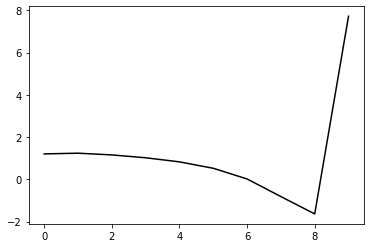

82000 0.2582091989270172
0.2172575297892204 -0.136748319766613 0.2441482128907017 0.11314524156578654
[ 1.22827724  1.14599074  1.07248912  0.95185368  0.75314668  0.43548596
 -0.08274408 -0.92627401 -1.76184806  7.70258508]


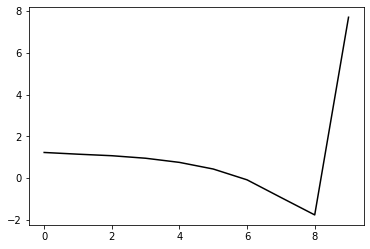

83000 0.18471491441236035
0.21487312024658514 -0.1322457991627206 0.24060783188304402 0.11491447775378302
[ 1.24360291  1.23082799  1.157377    1.02290883  0.81010217  0.48028951
 -0.04572116 -0.89654169 -1.74366312  7.73284653]


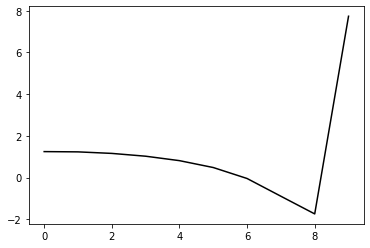

84000 0.17584532024298655
0.2184226834520819 -0.13718816913132612 0.24357846062079166 0.11411016246955145
[ 1.2045283   1.18733446  1.10929963  0.98998778  0.79998048  0.48459106
 -0.03738898 -0.88124309 -1.71657467  7.74100243]


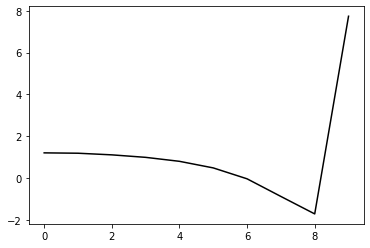

85000 0.22427255196339277
0.21709975090723493 -0.14182000205076464 0.24685851089668723 0.11303865520397079
[ 1.20734756  1.16496356  1.08269372  0.95909779  0.78037737  0.48771561
 -0.01060718 -0.83658158 -1.65468405  7.73002551]


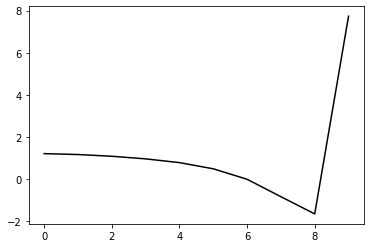

86000 0.2008060323524212
0.21329344270216066 -0.13761647708192754 0.24156892299064925 0.11343636997318284
[ 1.24029387  1.13209071  1.02216088  0.86564978  0.64824126  0.33407134
 -0.16425687 -0.98098712 -1.78853697  7.70696806]


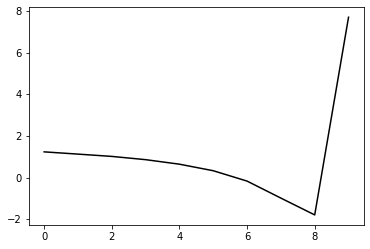

87000 0.2501506299231524
0.21605347968209151 -0.14280883102203873 0.24450668505236092 0.11744295388966026
[ 1.16205501  1.20066073  1.12047608  0.98833139  0.78985177  0.47440508
 -0.03191838 -0.84081831 -1.62843568  7.73951413]


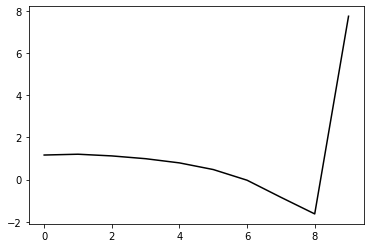

88000 0.18124933177369612
0.21982424592158256 -0.13801361326189915 0.24173098164248205 0.11882132681137689
[ 1.16361826  1.23367003  1.19745865  1.08183908  0.87959006  0.55900259
  0.04348948 -0.77797293 -1.57456538  7.76152953]


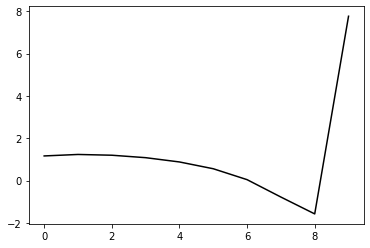

89000 0.24221376277598347
0.2170078738553074 -0.1398076781670372 0.24202160149106888 0.11374340364735841
[ 1.18247774  1.14700358  1.03620721  0.88258635  0.65788504  0.32109219
 -0.20699851 -1.04400303 -1.85450797  7.69090348]


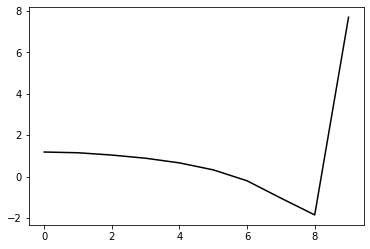

90000 0.17785879536618796
0.21722591527739157 -0.142975079190899 0.24203945284837322 0.119194070155381
[ 1.18444176  1.18730947  1.10737173  0.96321878  0.7494975   0.41145336
 -0.12592864 -0.96558291 -1.76579882  7.73306689]


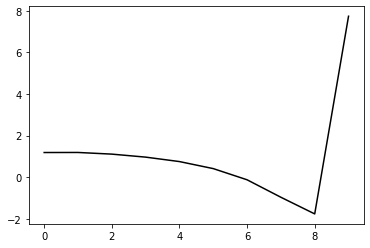

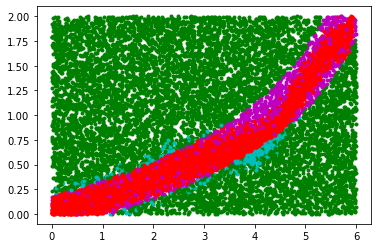

91000 0.21309301537707978
0.21364813051966497 -0.14368290872700995 0.2417499512616228 0.11983335821412389
[ 1.16916239  1.13362392  1.06035557  0.94362003  0.75675853  0.44281941
 -0.08496269 -0.92851469 -1.73023763  7.73524584]


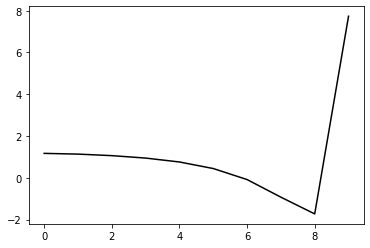

92000 0.27430996419567016
0.21188663837504157 -0.1402275322835217 0.2391347136840686 0.11824256835123043
[ 1.19843274  1.13733795  1.0588374   0.92202877  0.71773547  0.39399799
 -0.13476609 -0.98575862 -1.79707974  7.73766487]


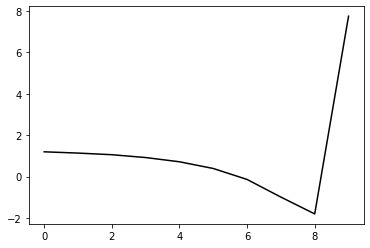

93000 0.17992883968384824
0.21353081527670992 -0.14310581185119303 0.24173140215513733 0.1156836221386103
[ 1.17567493  1.13181781  1.01579075  0.87871606  0.68012445  0.3641827
 -0.15433393 -0.99539728 -1.79905335  7.74934559]


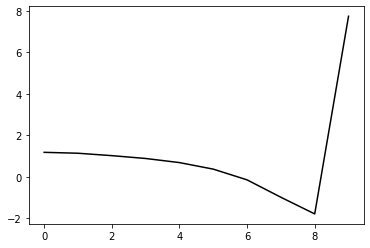

94000 0.21615997294450923
0.2181876611889213 -0.14426407322318163 0.24351323892755397 0.11643202426306318
[ 1.17922029  1.16139311  1.08877414  0.96557586  0.77142376  0.45544868
 -0.05965878 -0.89269756 -1.69030518  7.7370792 ]


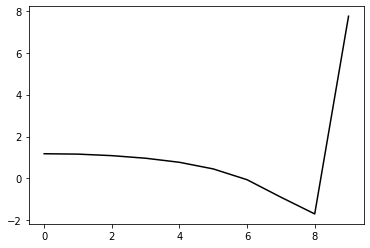

95000 0.2254113399821103
0.21981058234349543 -0.1437946492320375 0.24174841204166267 0.11770389496230754
[ 1.16182753  1.11466259  0.99375188  0.85447155  0.6552012   0.33212929
 -0.19353649 -1.03480495 -1.83926661  7.70290555]


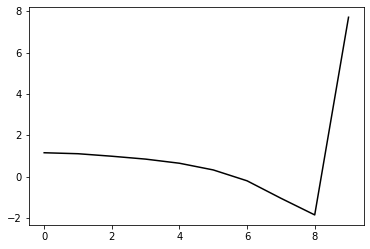

96000 0.24202261027500377
0.2202016761118442 -0.1429833864817546 0.241509990319334 0.11616168757266958
[ 1.17424636  1.15752949  1.04894359  0.91332658  0.71314815  0.39548333
 -0.12120836 -0.95670292 -1.75931082  7.71861019]


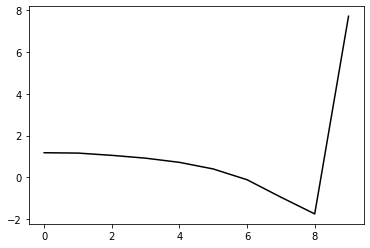

97000 0.20275805988499482
0.21703032949137968 -0.14093603148195952 0.239239334178073 0.11779040900541338
[ 1.19525137  1.19675632  1.12779169  1.00980509  0.81526794  0.49732865
 -0.02055516 -0.8586134  -1.67262766  7.75866338]


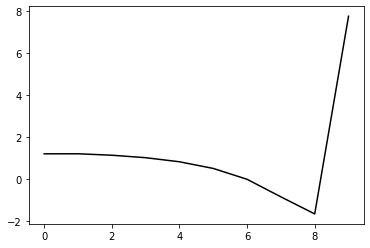

98000 0.1418771217463455
0.21165612518540006 -0.14556364137378927 0.24145143030784225 0.1133782917401083
[ 1.22460662  1.10634616  0.98985021  0.8415808   0.63102696  0.31665274
 -0.19007286 -1.02210803 -1.84068276  7.68713331]


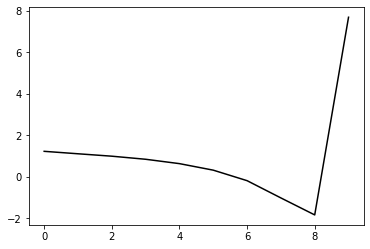

99000 0.14423708123411594
0.2154296623005976 -0.14137667481063718 0.2398478322032218 0.11142238734968712
[ 1.19749495  1.22984019  1.14327543  0.99899404  0.78748746  0.45932945
 -0.06734411 -0.91415446 -1.75351478  7.72566853]


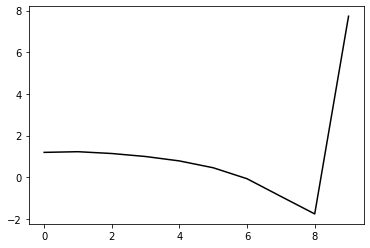

In [23]:
optimizer=tf.optimizers.Adam(learning_rate=0.0005)
for j in range (10000):    
    with tf.GradientTape() as g:
        loss=Error_func(h, m2, lam, alpha, beta, Positive[j%set], Negative[j%set])
        gradients=g.gradient(loss, [h, m2, lam, alpha, beta])
        if np.isnan(loss)==True: break
    for i in range (90):
        optimizer.apply_gradients(zip(gradients, [h]))
        if any(np.isnan(h.numpy()))==True: break
    for i in range (10):
        optimizer.apply_gradients(zip(gradients, [h, m2, lam, alpha, beta]))
        if any(np.isnan(h.numpy()))==True: break
    if j%100==0: 
        print(j*10, Error_func(h, m2, lam, alpha, beta, Positive[np.int32((j/set)%set)], Negative[np.int32((j/set)%set)]).numpy())
        print(m2.numpy(), lam.numpy(), alpha.numpy(), beta.numpy()), print(h.numpy())
        plt.plot(h.numpy(), 'k-'), plt.show()
    if j%1000==0:
        for i in range (set):
            [Positive0[i], Positive1[i]]=NN_func_01(h, m2, lam, alpha, beta, Positive[i])
            [Negative0[i], Negative1[i]]=NN_func_01(h, m2, lam, alpha, beta, Negative[i])
        for i in range (set):
            x_data1[i]=[v[0] for v in Positive0[i]]
            y_data1[i]=[v[1] for v in Positive0[i]]
            x_data2[i]=[v[0] for v in Positive1[i]]
            y_data2[i]=[v[1] for v in Positive1[i]]
            x_data3[i]=[v[0] for v in Negative0[i]]
            y_data3[i]=[v[1] for v in Negative0[i]]
            x_data4[i]=[v[0] for v in Negative1[i]]
            y_data4[i]=[v[1] for v in Negative1[i]]
            plt.plot(x_data4[i], y_data4[i], 'g.')
            plt.plot(x_data2[i], y_data2[i], 'c.')
            plt.plot(x_data1[i], y_data1[i], 'r.')
            plt.plot(x_data3[i], y_data3[i], 'm.')
        plt.show()

0 0.5287996112463975
0.22143532831044138 -0.14950692974260896 0.24689679638256912 0.10360350191881829
[ 1.15830038  1.23661576  1.13525212  1.01153716  0.82014537  0.50414492
 -0.02232347 -0.87257284 -1.71411236  7.73866277]


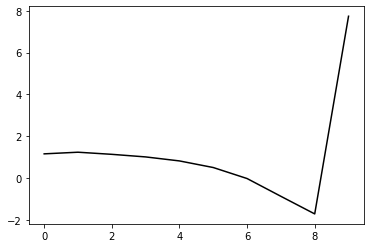

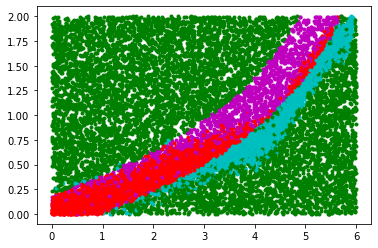

1000 0.2769411212609419
0.21942264388373542 -0.14511995886522427 0.24030689494296212 0.11864985350184196
[ 1.19146903  1.13382516  1.06018446  0.93698627  0.74313983  0.43176015
 -0.08318598 -0.92522721 -1.75803169  7.72912906]


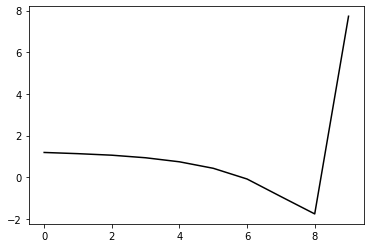

2000 0.21677344022394487
0.2178562949770687 -0.14802586873182547 0.2413747109383795 0.11605711850660065
[ 1.19619359  1.14164767  1.02913988  0.88446553  0.66971601  0.33808245
 -0.18641143 -1.0305041  -1.8635708   7.67589809]


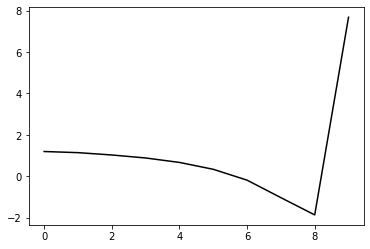

3000 0.21805843845683393
0.22232160542072052 -0.14448360240578945 0.24053494800097158 0.1133926305522792
[ 1.21085226  1.13195637  1.02478353  0.90842469  0.72719007  0.40293437
 -0.15136726 -1.03641689 -1.91509433  7.70490137]


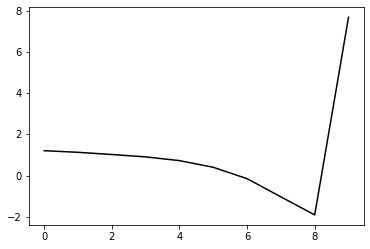

4000 0.24085200549806637
0.22164500283488564 -0.14404119282934877 0.23872013455349986 0.11786980308117123
[ 1.18015488  1.14179259  1.06068993  0.93429257  0.73961888  0.42226123
 -0.11061044 -0.98557217 -1.85337049  7.70841153]


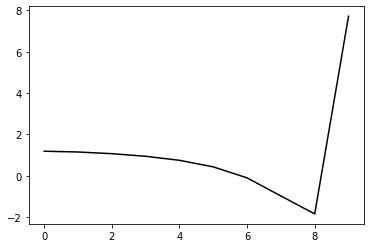

5000 0.18428830038711655
0.22023801269264784 -0.14805833928324968 0.24118804728520665 0.11913912978819813
[ 1.16315702  1.20391944  1.12957876  1.00047463  0.80179937  0.48659139
 -0.03697907 -0.90315333 -1.76822501  7.71731315]


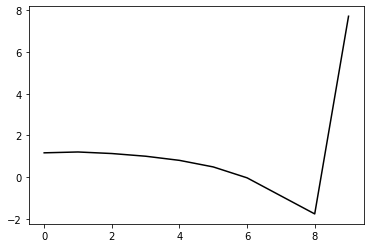

6000 0.315458254717721
0.21768791224664552 -0.14593230773357818 0.23966024566119432 0.11872167086104225
[ 1.21368035  1.14867395  1.09780784  0.97382577  0.7674878   0.44905968
 -0.07148019 -0.93319157 -1.80104635  7.73844718]


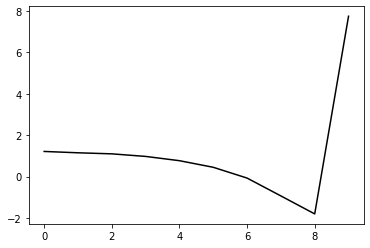

7000 0.18237695834788534
0.2170501543895693 -0.14117048383191733 0.23749923114179308 0.11562155619857996
[ 1.20607377  1.18336229  1.1023052   0.98204559  0.79146513  0.47204254
 -0.05721789 -0.923481   -1.80282329  7.71776096]


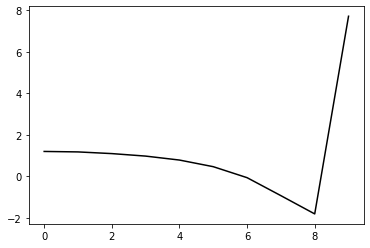

8000 0.2713700627257051
0.21864539143940356 -0.14119503805797134 0.238112532070094 0.11779779532175812
[ 1.17385282  1.20485805  1.13226997  1.00979709  0.82000622  0.51652032
  0.00836177 -0.83814641 -1.69965602  7.75013614]


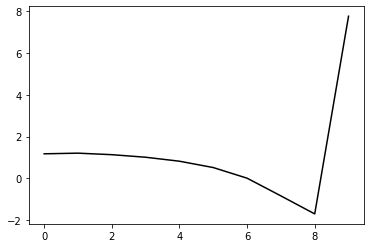

9000 0.29242839178628033
0.21793212836883633 -0.14797712459276763 0.2421865826054867 0.11626128824354552
[ 1.17121683e+00  1.18824612e+00  1.09849001e+00  9.75003143e-01
  7.87464808e-01  4.90490566e-01 -5.43301387e-04 -8.21018945e-01
 -1.65445306e+00  7.77009097e+00]


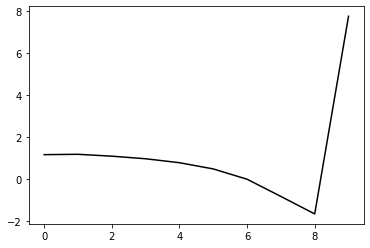

10000 0.3330490551053371
0.22274207577773478 -0.14534921282925023 0.24105061953927254 0.11334009103715206
[ 1.16221426  1.19520028  1.12278227  0.98217103  0.77311034  0.45612628
 -0.04562441 -0.86664007 -1.69855905  7.74889437]


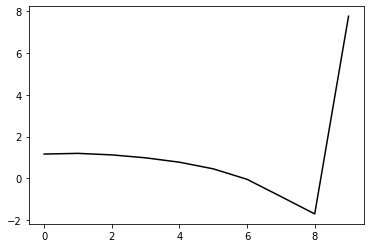

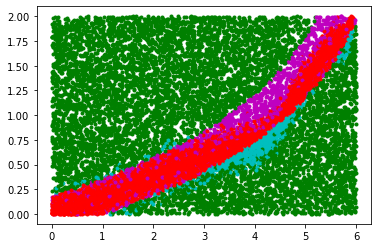

11000 0.26428483301602307
0.22024917537859623 -0.1441956589786141 0.24068533660462246 0.11480900880051471
[ 1.18664115  1.20042264  1.1213501   1.00468551  0.81819181  0.5148774
  0.01775696 -0.79689489 -1.62404339  7.75693108]


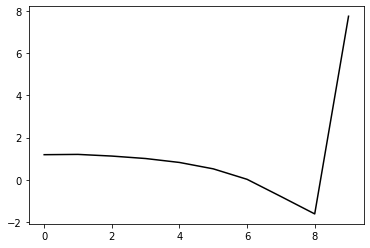

12000 0.193922578186563
0.2192234699318069 -0.14441843995321368 0.2399241819981662 0.11510257307412187
[ 1.21364097  1.18858602  1.11246749  0.9777491   0.77904362  0.47402057
 -0.01615307 -0.81595413 -1.61709407  7.79568536]


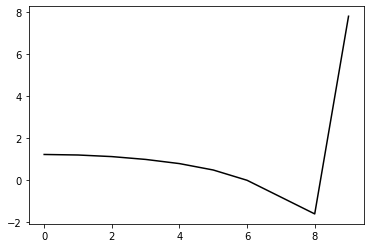

13000 0.2787350927250743
0.21783320865783629 -0.14678221946522976 0.24188011647127544 0.11102214621400605
[ 1.19025764  1.15486307  1.07632224  0.95321287  0.76144414  0.45809672
 -0.03303645 -0.82699246 -1.61525308  7.75980903]


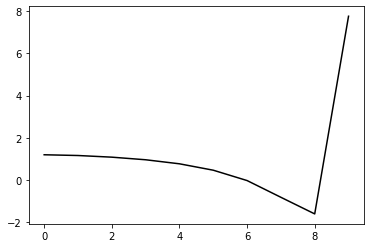

14000 0.24880193485027668
0.2096582239530925 -0.14218784554652997 0.23593027508115416 0.11686024312881128
[ 1.31402616  1.13230076  1.06961181  0.93276519  0.7239473   0.40777643
 -0.09096028 -0.88676186 -1.66557425  7.80495249]


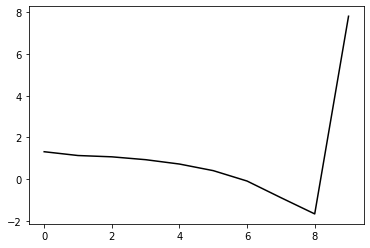

15000 0.1697874936733274
0.21567930986728484 -0.1459103681045962 0.2397848547327253 0.11281358814082956
[ 1.20986512  1.20741344  1.12589188  1.00571496  0.81470334  0.49846201
 -0.01304353 -0.81849943 -1.59667582  7.75895462]


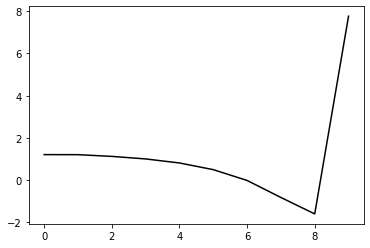

16000 0.24060561878174871
0.2117074604812544 -0.14564367773462727 0.23823871330202911 0.11237397419242955
[ 1.22862991  1.14005016  1.03855081  0.90538183  0.70487453  0.3856607
 -0.13082231 -0.94817871 -1.72869665  7.68605703]


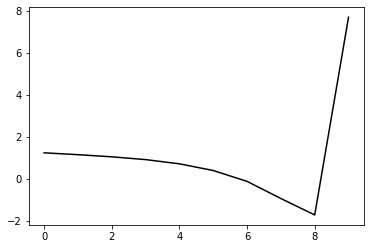

17000 0.2149942525075006
0.21331935387536877 -0.13943296526470125 0.23553294472304417 0.11187410001776807
[ 1.19670098  1.21216457  1.14288058  1.01669716  0.81155222  0.49322987
 -0.0179877  -0.8394215  -1.63017398  7.76320438]


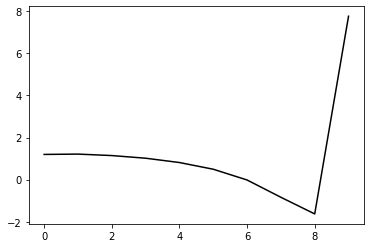

18000 0.23669062048991943
0.21116281753971683 -0.14501187332949894 0.2385435124878353 0.11307745379721067
[ 1.19677493e+00  1.20480792e+00  1.13935762e+00  1.00633720e+00
  8.07513971e-01  5.01727970e-01  7.58044627e-03 -7.93955631e-01
 -1.56314334e+00  7.76584498e+00]


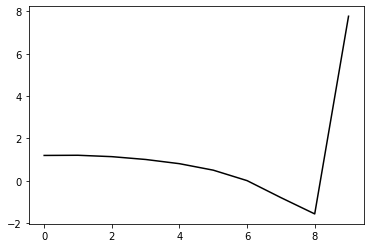

19000 0.24769971722092132
0.21279219655037665 -0.1488846912609745 0.240387147518317 0.11193472739204466
[ 1.19049816  1.13758417  1.01753492  0.86519545  0.64815926  0.33068059
 -0.16388633 -0.95564293 -1.70718495  7.74295433]


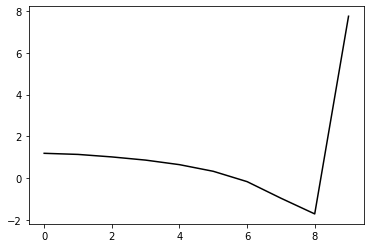

20000 0.26091644537697917
0.2154101169324618 -0.14927715538990763 0.2402981994969347 0.11346310502600854
[ 1.17349746  1.14096296  1.0166518   0.86730888  0.66144553  0.33894349
 -0.17449651 -0.97369368 -1.71736237  7.76127738]


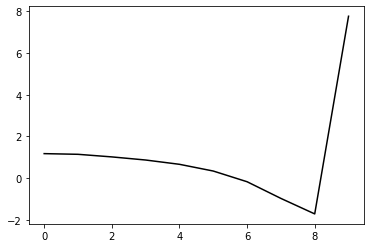

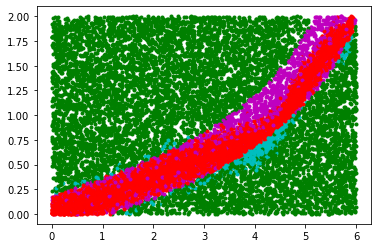

21000 0.17311784711202566
0.2170360898543096 -0.14478561853881888 0.2369042848819695 0.11954760989689012
[ 1.19062882  1.17855627  1.10648598  0.97190143  0.76158056  0.43476267
 -0.08416387 -0.89440421 -1.64364512  7.7554284 ]


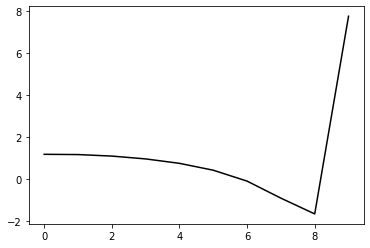

22000 0.218127093075868
0.21658598095645903 -0.1477215033112217 0.24061353018370246 0.11104092495551267
[ 1.19096345  1.15477943  1.03188533  0.88288234  0.6778753   0.3663973
 -0.13790119 -0.94471868 -1.69488252  7.70837328]


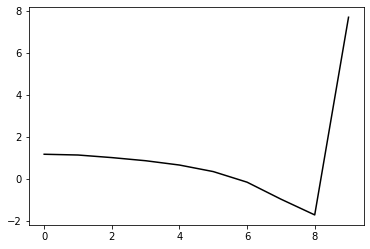

23000 0.2159456856513748
0.21650037330503663 -0.14493316678152815 0.2381102354657959 0.1149620232701474
[ 1.21582013  1.13245908  1.07208518  0.95300784  0.74634727  0.41983205
 -0.09268204 -0.8997599  -1.64608263  7.74774621]


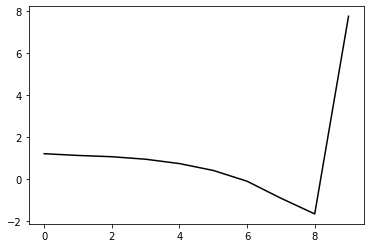

24000 0.09785674953550186
0.2178809128955031 -0.14356529123341127 0.23757605570121051 0.11341710859621518
[ 1.20146457  1.22877839  1.14226436  0.9993772   0.79036717  0.4655846
 -0.05543977 -0.87314702 -1.6267256   7.7470044 ]


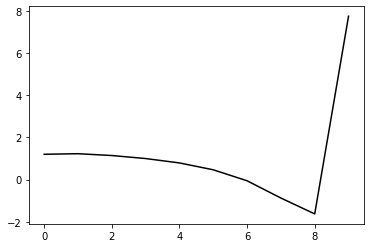

25000 0.19261547171354673
0.21636301931257465 -0.14366153359202366 0.2367948775424905 0.11339218287666332
[ 1.21721323  1.22533713  1.14992301  1.02389311  0.82551751  0.51363804
  0.00832694 -0.80036692 -1.54810075  7.79439309]


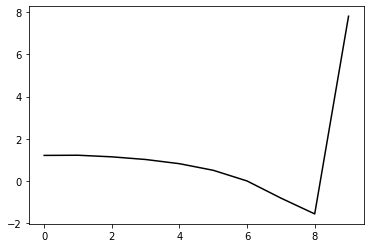

26000 0.21556534035627825
0.21629427761093234 -0.143758176068634 0.2370420906718383 0.11098862823046463
[ 1.19901053  1.22883318  1.17779558  1.06931432  0.87386314  0.55900399
  0.05451081 -0.75413    -1.50944045  7.78918075]


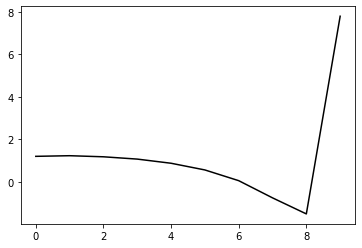

27000 0.17838310105266644
0.21496177256208301 -0.1448417915982386 0.23698819862604706 0.11121193617624443
[ 1.28269346e+00  1.19313818e+00  1.12609895e+00  1.00254689e+00
  8.07422074e-01  5.02674901e-01  6.77109405e-03 -7.90794519e-01
 -1.53138762e+00  7.78709373e+00]


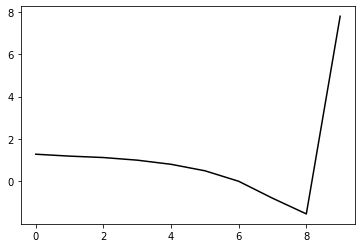

28000 0.343851139561503
0.22133229363100293 -0.14956271408417487 0.24078389373957468 0.11034084249798164
[ 1.1779644   1.152008    1.06790105  0.93332813  0.73354851  0.43287513
 -0.04420212 -0.81388595 -1.52088087  7.76589518]


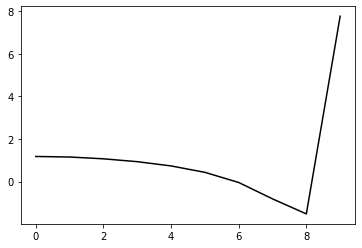

29000 0.30381052389586877
0.2192765601366527 -0.1510647303875425 0.24081060983376695 0.10908472104415617
[ 1.21491508  1.17278271  1.04092786  0.88276753  0.66387415  0.33865315
 -0.16049725 -0.93753011 -1.64372376  7.72784397]


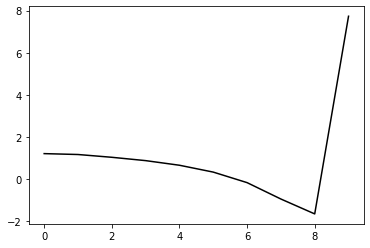

30000 0.19269127163669864
0.22175124711111577 -0.145985470965165 0.23776966532334062 0.11439256510247717
[ 1.22360134  1.23567964  1.16191537  1.03353721  0.82910125  0.50417196
 -0.00954018 -0.79873776 -1.50797515  7.79403978]


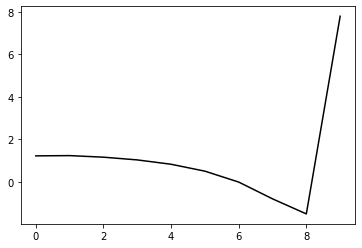

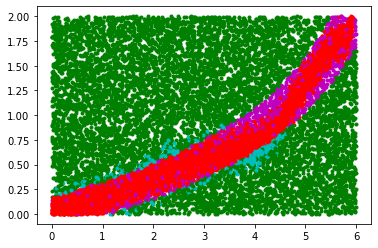

31000 0.23971915184548015
0.21982795749440276 -0.14847257222982904 0.2389122815254303 0.11070831865255189
[ 1.19637706  1.16800638  1.04361549  0.90413176  0.70432926  0.38865842
 -0.12081473 -0.91594929 -1.62435913  7.75287203]


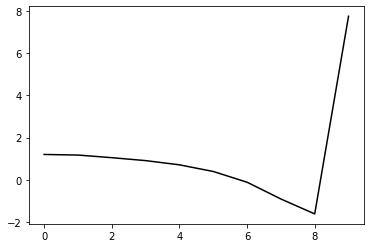

32000 0.19701364564019513
0.22231920744246214 -0.14204872528958126 0.23472310906821775 0.1132973101474123
[ 1.19565301e+00  1.25121034e+00  1.17114472e+00  1.03545567e+00
  8.29313324e-01  5.07604475e-01 -4.76282267e-03 -8.07017950e-01
 -1.52199692e+00  7.77868311e+00]


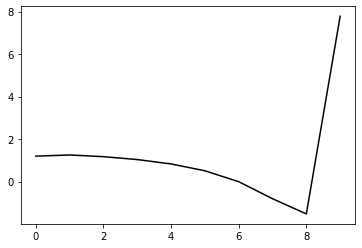

33000 0.20675332747676856
0.21949835017157993 -0.1469282797106997 0.23731589111549922 0.11213422981424272
[ 1.20982191  1.20944375  1.13275589  0.99092999  0.78097131  0.46515824
 -0.03398127 -0.82449202 -1.52935823  7.77819528]


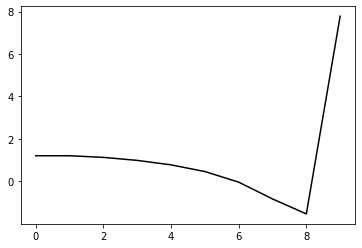

34000 0.26455696703231835
0.2169941699216826 -0.15067839394506852 0.24010096532637565 0.10838432031585599
[ 1.23251174  1.13650812  0.99269372  0.8399707   0.6397029   0.3358643
 -0.15075592 -0.92239036 -1.60641368  7.73827799]


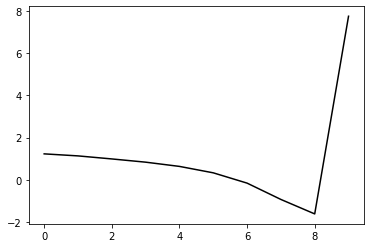

35000 0.20412518925162979
0.22283117888635567 -0.14576911070091436 0.2380797793675397 0.1103161347860787
[ 1.21218071  1.24618185  1.1780335   1.04550148  0.83655449  0.50368393
 -0.01540055 -0.81399531 -1.52539838  7.77184151]


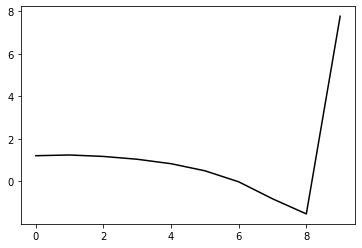

36000 0.1524080431480009
0.21730590387378204 -0.15023067220776537 0.23996362231961807 0.1108842050367359
[ 1.2182055   1.17357636  1.09770095  0.97535718  0.78309523  0.481356
 -0.01200391 -0.79391901 -1.48444455  7.80148121]


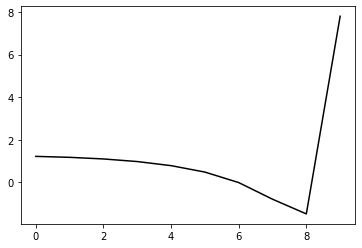

37000 0.2571371644580606
0.21982736609258946 -0.14974161285983084 0.2408990510234675 0.11049379049315937
[ 1.21065185  1.26956457  1.19926883  1.08126358  0.89378279  0.58689592
  0.08678486 -0.70726541 -1.4176045   7.78206105]


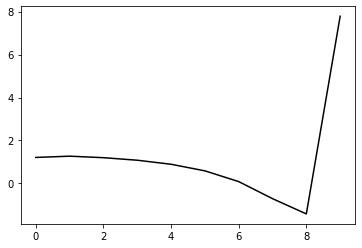

38000 0.1823926200012531
0.21682517747234847 -0.1455666331226099 0.23659801997998448 0.11235565223700131
[ 1.28488312  1.13560151  1.03569953  0.89131826  0.68337874  0.37406159
 -0.11747844 -0.90396893 -1.60998896  7.74038966]


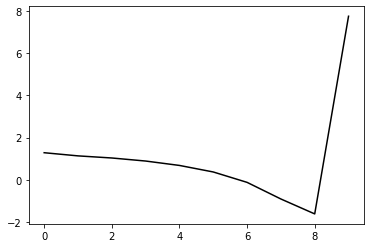

39000 0.14879362390616668
0.2185525877331389 -0.1476028172112657 0.23816189428424134 0.11069862964011173
[ 1.23489136  1.1450658   1.06087828  0.93626714  0.73901848  0.42175097
 -0.08202165 -0.87116803 -1.57781432  7.76696905]


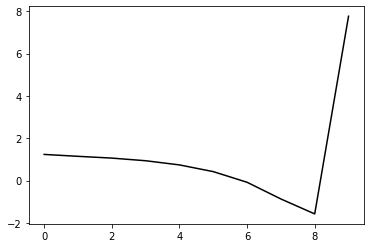

40000 0.23430336040510163
0.22247768022944767 -0.1424396833085782 0.2352684846770475 0.11056636442924861
[ 1.21094734e+00  1.27170712e+00  1.19588335e+00  1.05953850e+00
  8.47860295e-01  5.22682412e-01  6.93898777e-03 -7.98347629e-01
 -1.51984545e+00  7.78050755e+00]


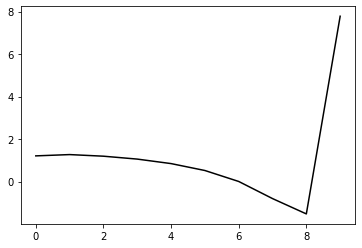

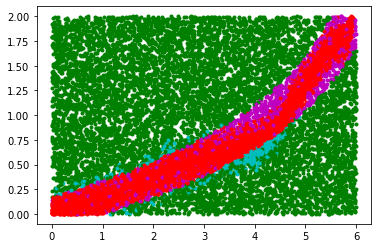

41000 0.17032696732386526
0.22061017012483616 -0.1438417353050516 0.23431345347939558 0.11168531859299839
[ 1.23888389  1.24874078  1.16992141  1.01942431  0.7974643   0.4582211
 -0.07433268 -0.89636322 -1.6301252   7.75253247]


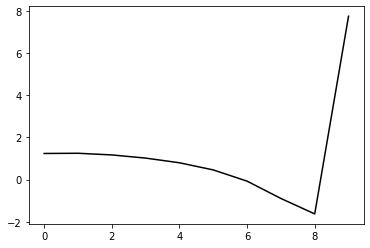

42000 0.24400074423324167
0.2176712619014701 -0.14817560298364857 0.23541149633225647 0.1157259484115577
[ 1.17302801  1.2274421   1.16176449  1.04700403  0.85094021  0.53011175
  0.01058956 -0.80182597 -1.51996568  7.77311018]


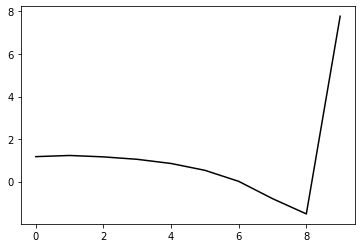

43000 0.20028531539198588
0.21628558226278446 -0.1509531713651846 0.23582523085339488 0.11464955035261819
[ 1.17486266  1.2188567   1.12783236  0.97654877  0.75572782  0.43153545
 -0.07944695 -0.88379874 -1.59059878  7.7409191 ]


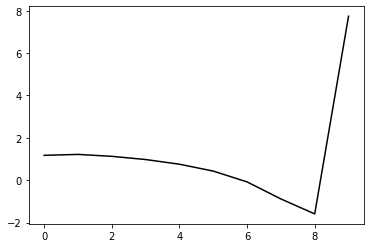

44000 0.21715498587438056
0.21479812076819071 -0.15597590630285746 0.23875495911475036 0.11603653587727263
[ 1.17641386  1.14610528  1.06759554  0.95057176  0.75881049  0.448807
 -0.05107294 -0.83941745 -1.52882401  7.74750351]


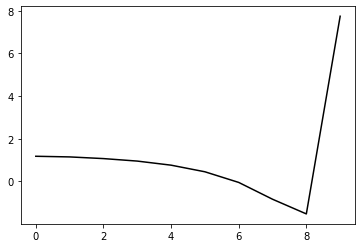

45000 0.22686503305014188
0.21629230985339223 -0.15132864855579647 0.23591630927365992 0.11241650013338783
[ 1.18815682  1.21809073  1.10519547  0.95619345  0.7458983   0.43152649
 -0.06999421 -0.86497646 -1.56754987  7.78848149]


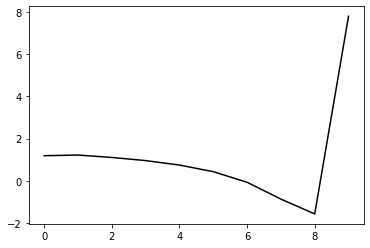

46000 0.2161408555694883
0.22292958063720603 -0.14902430582698525 0.2344666863475301 0.11710140641544733
[ 1.18067476  1.26985096  1.18144993  1.01500658  0.7754908   0.4254186
 -0.10523592 -0.92149872 -1.6447313   7.75808442]


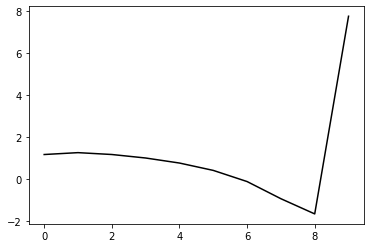

47000 0.3226779655046564
0.22027844719132786 -0.15301720055802126 0.2360022202856592 0.11814217173273249
[ 1.16750934  1.18927882  1.09999682  0.96578998  0.75916796  0.42030705
 -0.12173297 -0.9515525  -1.68503406  7.73368715]


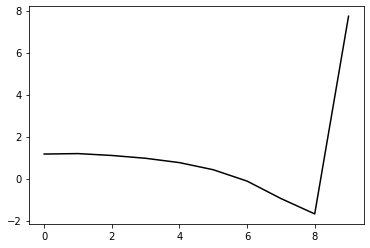

48000 0.12010811593159407
0.2199775962915573 -0.14728838682428416 0.23430019196226673 0.11532406156680061
[ 1.214065    1.17174005  1.10514244  0.98138072  0.78431134  0.46843793
 -0.05937667 -0.90259768 -1.66623662  7.74906565]


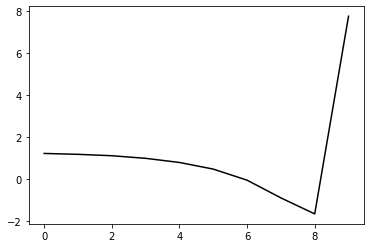

49000 0.17022842105849514
0.22251366071955475 -0.14834442640658774 0.236142933188078 0.1115977288865842
[ 1.20225548  1.21874578  1.11398721  0.95880317  0.73524965  0.40858788
 -0.10960681 -0.94398042 -1.70630722  7.7344913 ]


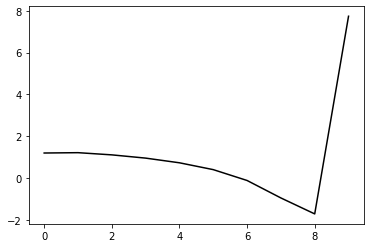

50000 0.2590564649870007
0.2228824594407652 -0.14987396117010252 0.2377937385134791 0.11343193141410303
[ 1.21544257  1.26672107  1.21077565  1.08236769  0.87926842  0.55696026
  0.03547526 -0.79702026 -1.56693114  7.75928057]


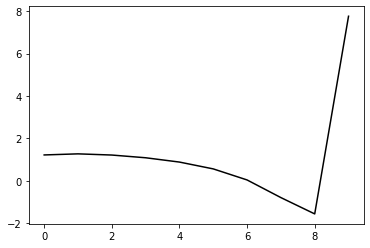

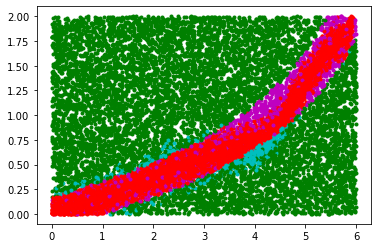

51000 0.2308406087780241
0.22081946045767345 -0.14994510083730223 0.23720614540257323 0.11310340488809728
[ 1.25965367  1.16195711  1.07150145  0.92810229  0.71982868  0.40173271
 -0.11678247 -0.94921927 -1.72214164  7.7156217 ]


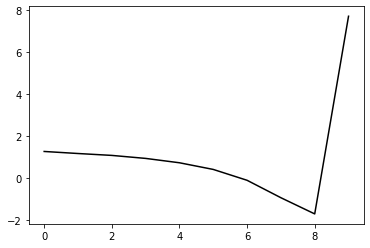

52000 0.2677496149341842
0.2250734913056333 -0.15290012236832556 0.24020769261297914 0.11260936755135187
[ 1.20066379e+00  1.20905320e+00  1.13611546e+00  1.02137169e+00
  8.26963619e-01  5.10987870e-01  9.22439480e-04 -8.18517011e-01
 -1.58274043e+00  7.72889630e+00]


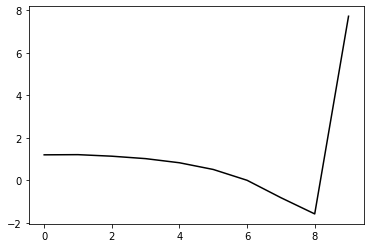

53000 0.2294319346514508
0.22514828500063605 -0.1502344083394669 0.2386200191384181 0.11082788114687117
[ 1.21721613  1.15945006  1.09264764  0.97725013  0.78411186  0.47152818
 -0.04029501 -0.86207427 -1.63142169  7.74616144]


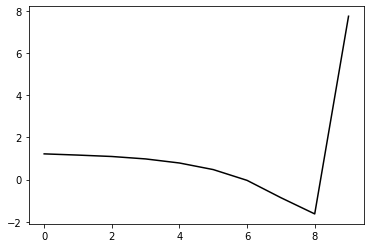

54000 0.16126577137056838
0.22449345277186641 -0.14811339070956708 0.236300427904852 0.11505891361389559
[ 1.22273367e+00  1.22642996e+00  1.15313193e+00  1.02947640e+00
  8.31462215e-01  5.11686398e-01 -2.34952287e-03 -8.21769527e-01
 -1.58722282e+00  7.76249603e+00]


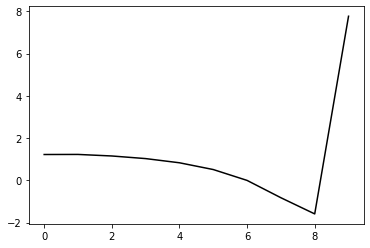

55000 0.21628311500171973
0.22409879480915132 -0.15088726242467582 0.23825180492643377 0.11188996515044963
[ 1.22795968  1.15490977  1.07201612  0.93588059  0.73494097  0.41773451
 -0.09720209 -0.91776136 -1.68263044  7.76738546]


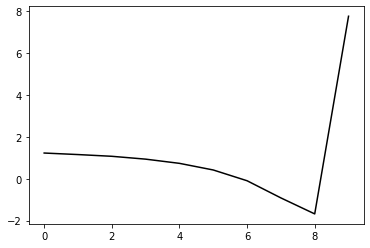

56000 0.16874524373457916
0.22437247464868634 -0.14707898536088304 0.23618527199985903 0.11153783625622475
[ 1.23470025  1.1641292   1.08966977  0.96519422  0.77099527  0.4554507
 -0.06138673 -0.88845485 -1.66541463  7.77819318]


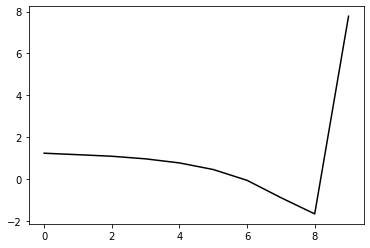

57000 0.19996803122699933
0.22249248532561933 -0.14785057613317035 0.2370121584459213 0.10925440877516492
[ 1.22729417  1.18937822  1.11183085  0.9785254   0.77719442  0.46483974
 -0.04502194 -0.86917179 -1.64806848  7.76941251]


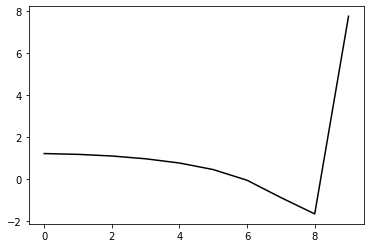

58000 0.27779745232622516
0.22350377450232228 -0.14659734236208788 0.2363516940708149 0.11162970672457186
[ 1.22495969  1.19793283  1.13182993  0.99418391  0.77883749  0.45943721
 -0.04727193 -0.86520455 -1.64192683  7.75168228]


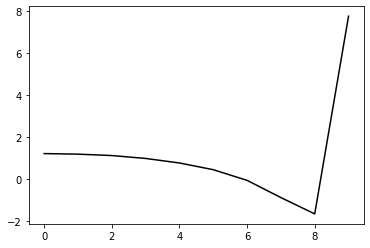

59000 0.2947192903686232
0.22254908032009993 -0.14668925196220023 0.23628170986980324 0.11349609502411521
[ 1.18094523  1.20203572  1.09822682  0.9696894   0.77241795  0.45466087
 -0.05786005 -0.87350841 -1.64399216  7.74938351]


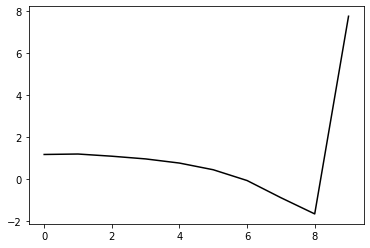

60000 0.19450677989962803
0.22312984490569018 -0.15029827765956513 0.2393749313883716 0.11053069058349071
[ 1.21113128  1.19159349  1.1127185   0.96851372  0.76243904  0.44452146
 -0.06771326 -0.88353882 -1.64898338  7.74044664]


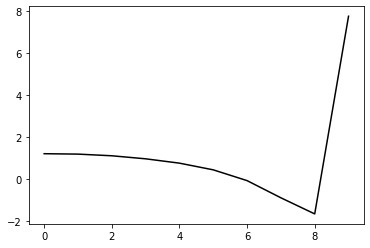

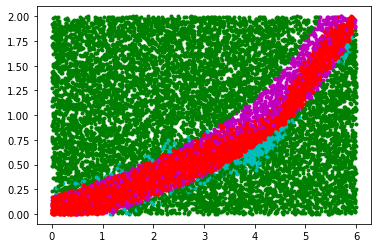

61000 0.16935789817194852
0.22276529442631346 -0.14638584696407056 0.23711229212761256 0.11297362682908392
[ 1.19526235  1.22924145  1.15754447  1.0319127   0.83316102  0.52434401
  0.02365074 -0.78161925 -1.53560467  7.76561785]


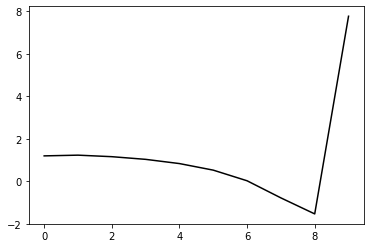

62000 0.15292865218456242
0.21737140773010222 -0.14958729096386947 0.23877235930512772 0.11137684413871642
[ 1.20640442  1.22594993  1.14500317  1.00930756  0.79882943  0.48220319
 -0.01886608 -0.8240645  -1.58267839  7.75396764]


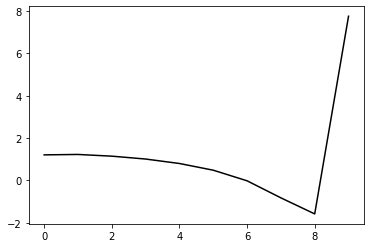

63000 0.2530744407543679
0.21772108899999348 -0.14994230155647711 0.2383595771341132 0.11273993370641373
[ 1.18855765e+00  1.23193068e+00  1.15911780e+00  1.02962137e+00
  8.30908057e-01  5.14542294e-01  7.16806379e-03 -7.95949997e-01
 -1.54654244e+00  7.76442576e+00]


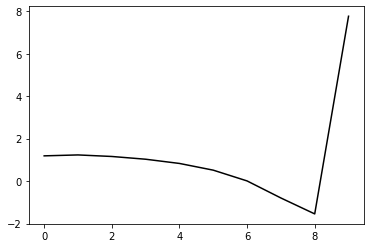

64000 0.20851385423687926
0.21778000771389602 -0.1494372992681538 0.23711785375648267 0.11059258887358774
[ 1.19324396  1.14855436  1.04194521  0.89966519  0.69303306  0.37379011
 -0.13987622 -0.94976408 -1.69716817  7.72995104]


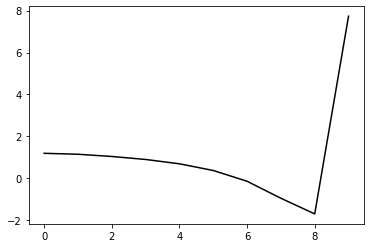

65000 0.2502145062520089
0.21936610914960883 -0.15119865820009645 0.23885009442118563 0.1121563157262539
[ 1.18033307e+00  1.23699981e+00  1.17064345e+00  1.04060000e+00
  8.34708473e-01  5.11606964e-01 -6.34094259e-03 -8.23202953e-01
 -1.57619065e+00  7.75303127e+00]


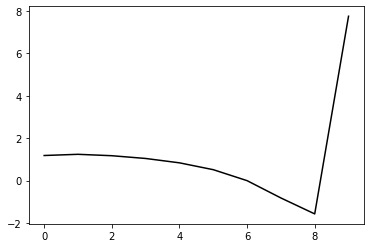

66000 0.3179762814213194
0.22122525748317307 -0.1515356776944202 0.24067075409412875 0.1086311249532207
[ 1.19342511  1.2024674   1.13664084  1.00807001  0.81654556  0.51392359
  0.00965762 -0.80614406 -1.56636446  7.75282954]


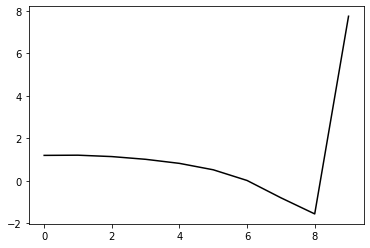

67000 0.2046530895548025
0.21669899380963137 -0.14716178046672854 0.2367289835616141 0.11244489565914129
[ 1.22221416  1.27245657  1.2202689   1.08560978  0.87640428  0.55497987
  0.03891992 -0.78931131 -1.57010052  7.76754618]


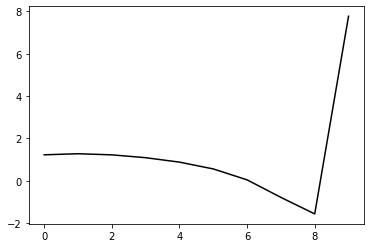

68000 0.26104265117595604
0.22063056626266345 -0.1467280616400426 0.2367974574205812 0.11192924275408148
[ 1.20469914  1.24388846  1.18866608  1.08939162  0.90345757  0.58684717
  0.06622698 -0.76804723 -1.55776241  7.73770872]


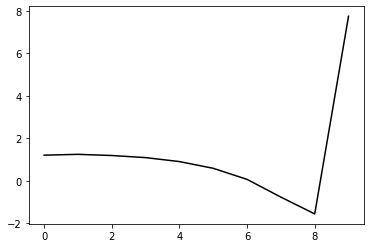

69000 0.1386197410452022
0.22384037341374896 -0.14692263604611905 0.23669540456730323 0.11268326128750111
[ 1.2215488   1.26311162  1.19686502  1.07500496  0.87864705  0.56310116
  0.04550341 -0.7858397  -1.56795759  7.76338322]


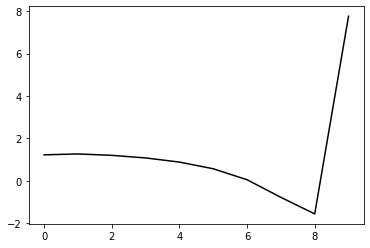

70000 0.21784755820815882
0.22322800236094523 -0.14836558756886212 0.23753761609041743 0.11135955404896844
[ 1.20726904  1.24881204  1.1846785   1.05801977  0.85477825  0.53688786
  0.02085411 -0.80815458 -1.58759959  7.753907  ]


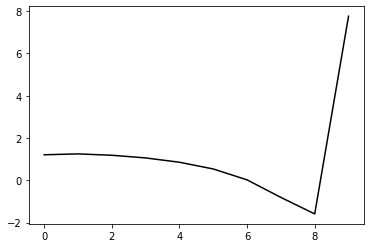

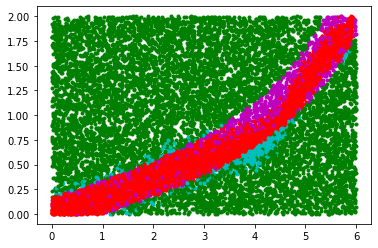

71000 0.24847219975563778
0.22384254420130262 -0.148138361820127 0.23726612200935415 0.10872567829595346
[ 1.23809243  1.27423706  1.18583373  1.03036826  0.81016214  0.48241529
 -0.04252461 -0.88376685 -1.67977602  7.74546097]


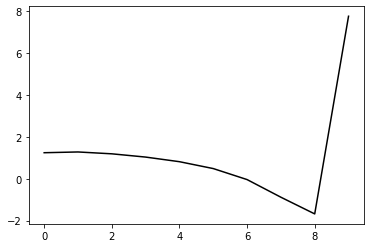

72000 0.2211702164943895
0.22110509469531608 -0.15109843913836518 0.2400841556536449 0.10976862558025596
[ 1.25568722  1.182624    1.12362527  1.01911913  0.84230223  0.53860842
  0.02426751 -0.81014438 -1.60578433  7.73265403]


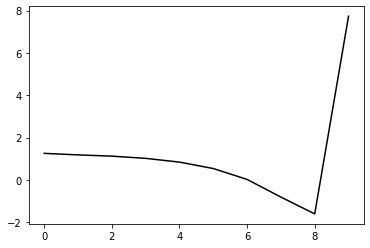

73000 0.23193817719230278
0.2222438524815372 -0.1468568168604768 0.2368169035697758 0.11138548623444741
[ 1.19959874  1.26029503  1.18937999  1.0669692   0.87189094  0.55572876
  0.03476434 -0.80912809 -1.61697745  7.77494076]


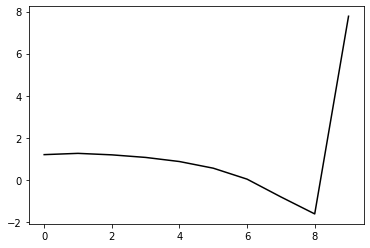

74000 0.22304565547917776
0.21870085440755035 -0.15122484245726697 0.23870468081783824 0.10982169497069502
[ 1.23193679  1.12428018  1.00174339  0.85522741  0.65880874  0.36050007
 -0.13662297 -0.96068188 -1.75481641  7.69698767]


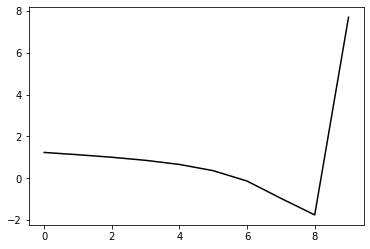

75000 0.24475766376678734
0.2202173379439699 -0.1470709710958444 0.23737133579804898 0.10945251671432316
[ 1.24546866e+00  1.18987611e+00  1.12528555e+00  1.00541745e+00
  8.11178601e-01  5.00279362e-01 -3.43540325e-03 -8.26177296e-01
 -1.62956331e+00  7.78771136e+00]


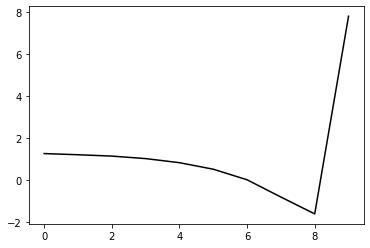

76000 0.3066440005475879
0.22231542485397432 -0.1511695121326981 0.23972724044088403 0.10944253188334789
[ 1.18987884  1.21244345  1.1600678   1.03756843  0.83872642  0.52647891
  0.02334189 -0.7926357  -1.58744668  7.78649211]


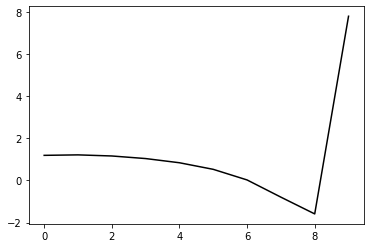

77000 0.26699487647802017
0.22131404697588455 -0.14827410253865062 0.23638179783841715 0.11257251215147498
[ 1.20392737  1.26321097  1.2000298   1.07433218  0.87254047  0.5530327
  0.03838343 -0.78386419 -1.57815124  7.76481006]


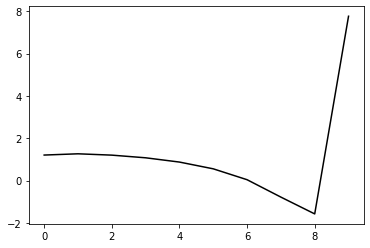

78000 0.22487618380063104
0.22274815463868308 -0.15147237456794402 0.23853993676075735 0.10950705962801369
[ 1.22410602  1.20051186  1.0980399   0.96694044  0.77490738  0.4634445
 -0.04902004 -0.86947005 -1.65650972  7.72140742]


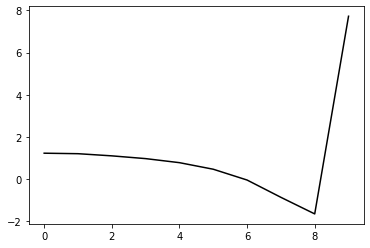

79000 0.18329148332540027
0.22027070671093577 -0.1487867868092782 0.23707363719760224 0.10708830744077986
[ 1.22799549  1.19613937  1.07915959  0.94699149  0.75562066  0.4492978
 -0.05924569 -0.88481391 -1.68236895  7.75146873]


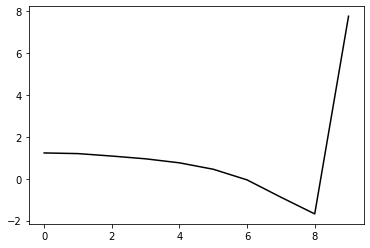

80000 0.21968328578317145
0.2241072929254066 -0.1496716435888707 0.23888024861218052 0.10494567481466764
[ 1.24542051  1.24312644  1.13519299  0.98257296  0.7742322   0.46257019
 -0.04477707 -0.86937098 -1.66791658  7.73170555]


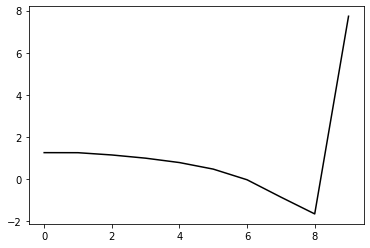

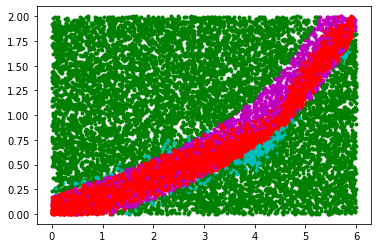

81000 0.2885400206542375
0.22896224842236299 -0.14975314681367718 0.23771779245395336 0.11107964079888037
[ 1.26688295  1.24559184  1.18018224  1.04793433  0.84092966  0.50275649
 -0.03882047 -0.88678081 -1.69948631  7.72874777]


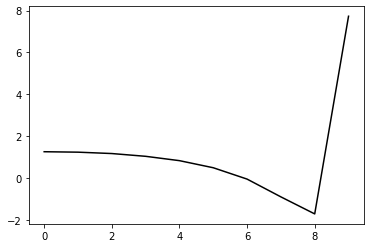

82000 0.25131816106613447
0.22259286266518785 -0.14961627976410113 0.23615146428731978 0.11153497035827774
[ 1.24289371e+00  1.22889439e+00  1.13829202e+00  1.01485955e+00
  8.31246062e-01  5.23051034e-01  3.51166497e-04 -8.46486964e-01
 -1.66420932e+00  7.71918871e+00]


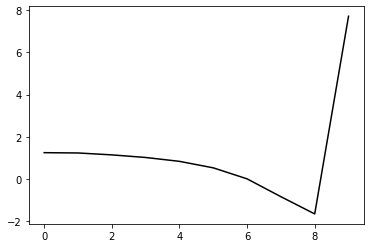

83000 0.18291658348438458
0.2188736843032282 -0.14757968694872853 0.23524563305598878 0.11001208995789769
[ 1.24601173  1.2031836   1.13837691  1.02466987  0.8455494   0.54640288
  0.03874428 -0.80455052 -1.63467889  7.75792947]


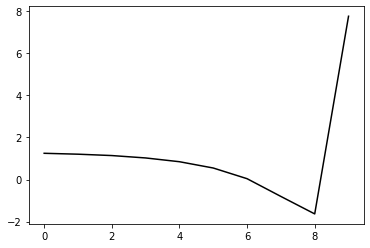

84000 0.191621088967236
0.21876250668271996 -0.14902743856295883 0.2360232020171618 0.10613402642435671
[ 1.21715518  1.14020399  1.02195564  0.86942204  0.65704115  0.34732725
 -0.14636784 -0.96590727 -1.77758183  7.72255951]


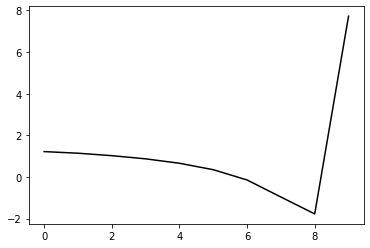

85000 0.25233815015034583
0.2155708971285765 -0.149947962880673 0.23422011684174368 0.11245971786080235
[ 1.26258065  1.11634683  1.01923952  0.89849544  0.70732383  0.38630976
 -0.13356358 -0.95872484 -1.76477288  7.73675168]


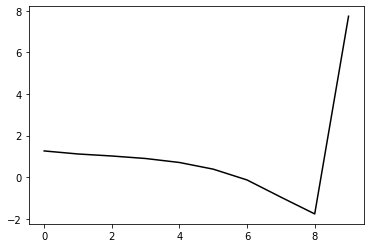

86000 0.20511490556261633
0.2148457592111554 -0.14606645522399878 0.23105565903575154 0.1153316111714435
[ 1.22558335  1.18689702  1.10807257  0.97721896  0.77512827  0.45727163
 -0.05897184 -0.88795926 -1.69384518  7.73730566]


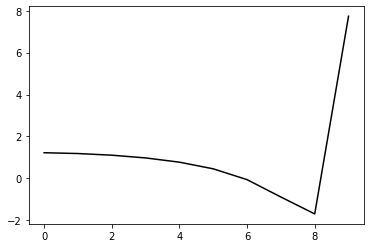

87000 0.28299231939409075
0.22271681838810978 -0.15205933693432283 0.23681671526558976 0.11032632509578436
[ 1.17198778  1.18301324  1.11950737  1.0063186   0.82257611  0.52267206
  0.02907594 -0.77668413 -1.55860208  7.78379001]


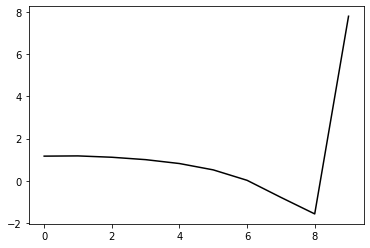

88000 0.17122187279951376
0.2231402826248881 -0.15105223750743338 0.23444833656647532 0.1120495624857823
[ 1.19085804  1.16481786  1.06362121  0.92504686  0.71727404  0.39730518
 -0.11030551 -0.92209123 -1.70296834  7.73493686]


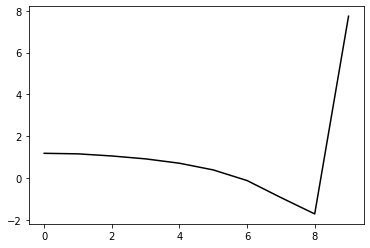

89000 0.2249313892526877
0.2206710151396357 -0.149263869991458 0.23268203228495077 0.11435668905184287
[ 1.24087059  1.14558859  1.05903491  0.92480188  0.71478761  0.38950483
 -0.12423864 -0.93986849 -1.7231167   7.71544793]


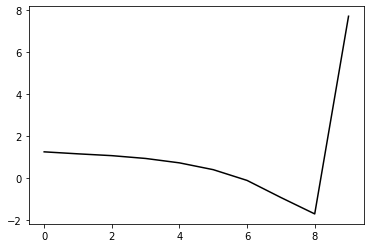

90000 0.1815270879580829
0.22251514929536018 -0.15106742932451203 0.23296991632277889 0.11788537193539168
[ 1.19756989  1.20109637  1.09938646  0.95860593  0.76130977  0.44686874
 -0.06424571 -0.87321359 -1.63728323  7.7564068 ]


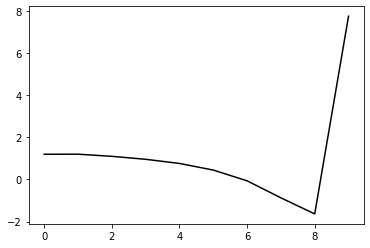

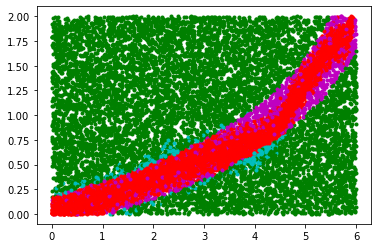

91000 0.2355395314521663
0.22448300656687 -0.15253139694978848 0.2353365756014764 0.11419097415127352
[ 1.1756929   1.18595695  1.08302572  0.94060305  0.73936423  0.43228818
 -0.06584611 -0.86960765 -1.63018444  7.73962881]


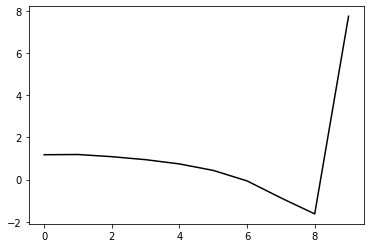

92000 0.28938337333479053
0.22389094753749036 -0.15344848002773015 0.236563440244299 0.11038568106880804
[ 1.20836686  1.20439999  1.10978827  0.96390337  0.74869228  0.43083658
 -0.07070728 -0.87886646 -1.65221208  7.73655405]


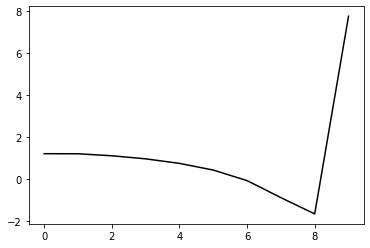

93000 0.1778363245822365
0.2258897054648639 -0.149637949812653 0.23471707701735098 0.11079334735609571
[ 1.20186792  1.26529397  1.18485583  1.05637639  0.86421559  0.55071695
  0.04076709 -0.77183569 -1.54892541  7.74114276]


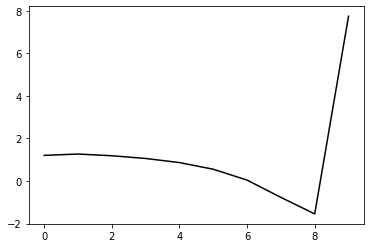

94000 0.1920553284493801
0.22495862487317203 -0.15159497431739272 0.2349076337982298 0.11044569656369918
[ 1.22511679  1.16862678  1.0879791   0.9583624   0.75773909  0.43381584
 -0.0886447  -0.91382205 -1.69542218  7.75647531]


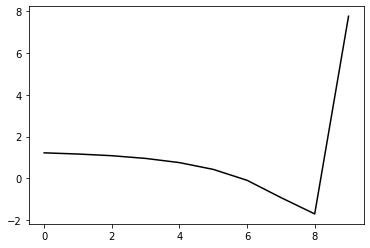

95000 0.34897239200665536
0.22397849580661916 -0.15384584355134204 0.23875813622198047 0.10661635832687849
[ 1.19803669  1.19356128  1.12587379  1.00719228  0.82511257  0.53498123
  0.04645851 -0.75750744 -1.52351341  7.77713257]


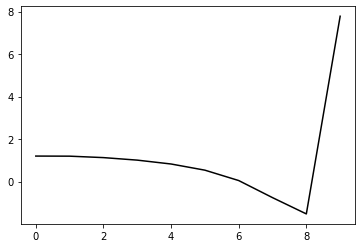

96000 0.1990500383059899
0.22022480785486634 -0.15262488539210362 0.2360409553701149 0.11017864796120137
[ 1.22866275  1.21637301  1.14200355  1.00624707  0.80507926  0.5002089
  0.01191004 -0.7845122  -1.54494113  7.76854938]


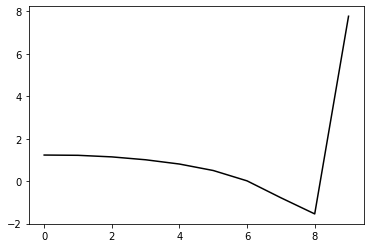

97000 0.21098436696959602
0.2160894544334656 -0.1529366669429964 0.23449989288293968 0.11019682069678619
[ 1.25854128  1.13991819  1.04289958  0.89851328  0.69143512  0.37931203
 -0.11636271 -0.91288754 -1.67585853  7.7376344 ]


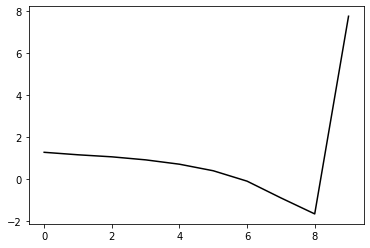

98000 0.15244911293803515
0.22359304280304249 -0.15362034651691506 0.23537360781046582 0.11291682291356833
[ 1.250005    1.15413794  1.09149153  0.97526965  0.78326283  0.47201338
 -0.02299701 -0.80229798 -1.53075054  7.79993212]


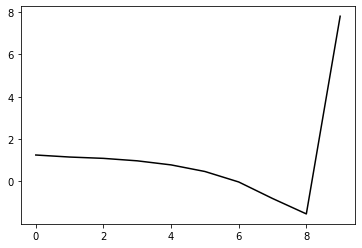

99000 0.1472772056663408
0.22455551870958987 -0.15316948951449857 0.23484757983220336 0.10695686607837958
[ 1.24264486  1.10423817  0.96011996  0.78656714  0.56250652  0.23410381
 -0.28113039 -1.08376178 -1.82806865  7.7071987 ]


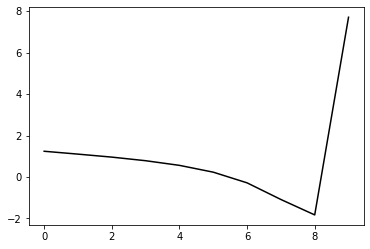

In [24]:
optimizer=tf.optimizers.Adam(learning_rate=0.0005)
for j in range (10000):    
    with tf.GradientTape() as g:
        loss=Error_func(h, m2, lam, alpha, beta, Positive[j%set], Negative[j%set])
        gradients=g.gradient(loss, [h, m2, lam, alpha, beta])
        if np.isnan(loss)==True: break
    for i in range (90):
        optimizer.apply_gradients(zip(gradients, [h]))
        if any(np.isnan(h.numpy()))==True: break
    for i in range (10):
        optimizer.apply_gradients(zip(gradients, [h, m2, lam, alpha, beta]))
        if any(np.isnan(h.numpy()))==True: break
    if j%100==0: 
        print(j*10, Error_func(h, m2, lam, alpha, beta, Positive[np.int32((j/set)%set)], Negative[np.int32((j/set)%set)]).numpy())
        print(m2.numpy(), lam.numpy(), alpha.numpy(), beta.numpy()), print(h.numpy())
        plt.plot(h.numpy(), 'k-'), plt.show()
    if j%1000==0:
        for i in range (set):
            [Positive0[i], Positive1[i]]=NN_func_01(h, m2, lam, alpha, beta, Positive[i])
            [Negative0[i], Negative1[i]]=NN_func_01(h, m2, lam, alpha, beta, Negative[i])
        for i in range (set):
            x_data1[i]=[v[0] for v in Positive0[i]]
            y_data1[i]=[v[1] for v in Positive0[i]]
            x_data2[i]=[v[0] for v in Positive1[i]]
            y_data2[i]=[v[1] for v in Positive1[i]]
            x_data3[i]=[v[0] for v in Negative0[i]]
            y_data3[i]=[v[1] for v in Negative0[i]]
            x_data4[i]=[v[0] for v in Negative1[i]]
            y_data4[i]=[v[1] for v in Negative1[i]]
            plt.plot(x_data4[i], y_data4[i], 'g.')
            plt.plot(x_data2[i], y_data2[i], 'c.')
            plt.plot(x_data1[i], y_data1[i], 'r.')
            plt.plot(x_data3[i], y_data3[i], 'm.')
        plt.show()

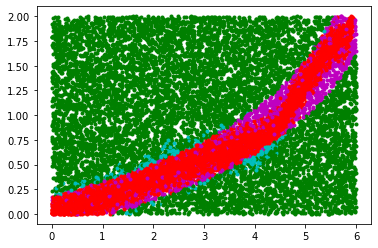

In [25]:
for i in range (set):
    [Positive0[i], Positive1[i]]=NN_func_01(h, m2, lam, alpha, beta, Positive[i])
    [Negative0[i], Negative1[i]]=NN_func_01(h, m2, lam, alpha, beta, Negative[i])
for i in range (set):
    x_data1[i]=[v[0] for v in Positive0[i]]
    y_data1[i]=[v[1] for v in Positive0[i]]
    x_data2[i]=[v[0] for v in Positive1[i]]
    y_data2[i]=[v[1] for v in Positive1[i]]
    x_data3[i]=[v[0] for v in Negative0[i]]
    y_data3[i]=[v[1] for v in Negative0[i]]
    x_data4[i]=[v[0] for v in Negative1[i]]
    y_data4[i]=[v[1] for v in Negative1[i]]
    plt.plot(x_data4[i], y_data4[i], 'g.')
    plt.plot(x_data2[i], y_data2[i], 'c.')
    plt.plot(x_data1[i], y_data1[i], 'r.')
    plt.plot(x_data3[i], y_data3[i], 'm.')
plt.show()

99990 0.1280214289721735
0.22325020089774647 -0.1505276731483339 0.23204264355526555 0.11400171775664177
[ 1.22464914  1.21045879  1.12862668  1.00357091  0.80054596  0.47441846
 -0.04517342 -0.8530817  -1.59509693  7.73267681]


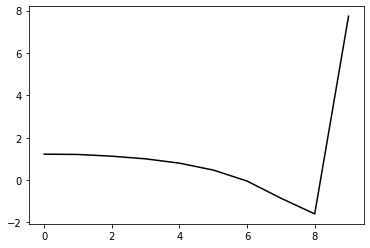

([<matplotlib.lines.Line2D at 0x24962118508>], None)

In [27]:
print(j*10, Error_func(h, m2, lam, alpha, beta, Positive[np.int32((j/set)%set)], Negative[np.int32((j/set)%set)]).numpy())
print(m2.numpy(), lam.numpy(), alpha.numpy(), beta.numpy()), print(h.numpy())
plt.plot(h.numpy(), 'k-'), plt.show()